In [48]:
# EE569 Homework Assignment #5 Sample Code
# requirements: python3 + pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import torchvision as tv
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter

In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

base_path = "/content/drive/MyDrive/DIP/HW5_models/"

Mounted at /content/drive


In [3]:
class Net(nn.Module):
    def __init__(self, num_channels=1):
        super(Net, self).__init__()
        self.num_channels = num_channels
        self.padding = 2 if num_channels == 1 else 0
        self.conv1 = nn.Conv2d(num_channels, 6, 5, stride=1, padding=self.padding)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution, with relu activation followed by max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Convolution, with relu activation followed by max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Flatten data
        x = x.view(-1, self.num_flat_features(x))

        # Linear with relu activation
        x = F.relu(self.fc1(x))

        # Linear with relu activation
        x = F.relu(self.fc2(x))

        # Linear classifier
        x = self.fc3(x)

        return x

    def num_flat_features(self, x):
        # x is a 4D tensor
        x_size = x.size()[1:]
        num = 1
        for n in x_size:
            num *= n
        return num

In [4]:
def load_data(dataset="MNIST", train_batch_size=64, test_batch_size=1000):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]
    )

    if dataset == "MNIST":
        train_set = tv.datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
        test_set = tv.datasets.MNIST(
            root='./data',
            train=False,
            download=True,
            transform=transform
        )

    if dataset == "FashionMNIST":
        train_set = tv.datasets.FashionMNIST(
            root="./data",
            train=True,
            download=True,
            transform=transform
        )
        test_set = tv.datasets.FashionMNIST(
            root="./data",
            train=False,
            download=True,
            transform=transform
        )

    if dataset == "CIFAR10":
        train_set = tv.datasets.CIFAR10(
            root="./data",
            train=True,
            download=True,
            transform=transform
        )
        test_set = tv.datasets.CIFAR10(
            root="./data",
            train=False,
            download=True,
            transform=transform
        )

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    print("data loaded successfully...")
    return train_loader, test_loader

In [5]:
def accuracy(model, x, neg=False):
    predictions = []
    with torch.no_grad():
        correct = 0
        total = 0

        for data in x:
            images, labels = data

            if neg:
                images = - images

            images, labels = images, labels

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = (100 * correct / total)

        return accuracy, predictions

In [6]:
def display(train_acc, test_acc):
    _, ax = plt.subplots()
    ax.plot(
        range(1, len(train_acc) + 1),
        train_acc,
        color='r',
        label='train_acc'
    )
    ax.plot(
        range(1, len(test_acc) + 1),
        test_acc,
        color='b',
        label='test_acc'
    )
    ax.legend(loc='lower right')
    plt.show()

In [7]:
def train_model(
    dataset="MNIST",
    model_number=1,
    learning_rate=0.001,
    max_epoch=15,
    optimizerName="SGD",
    add_scheduler=False,
    momentum=0.9,
    decay=0.9,
    step_size=15,
    train_batch_size=64,
    test_batch_size=1000,
    num_channels=1
):
    # input MNIST
    train_loader, test_loader = load_data(
        dataset,
        train_batch_size,
        test_batch_size
    )
    # new model
    net = Net(num_channels=num_channels)

    # training
    learning_rate = learning_rate
    momentum = momentum
    max_epoch = max_epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    scheduler=None

    if optimizerName == "SGD":
        optimizer = optim.SGD(
            net.parameters(),
            lr=learning_rate,
            momentum=momentum
        )

    if optimizerName == "Adam":
        optimizer = optim.Adam(
            net.parameters(),
            lr=learning_rate,
        )

    if add_scheduler:
        scheduler = StepLR(optimizer, step_size=step_size, gamma=decay)

    train_acc = []
    test_acc = []
    max_acc = 0

    for epoch in range(max_epoch):
        net.train()
        running_loss = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs, labels

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % 200 == 199:
                print(
                    "[epoch %d, iter %5d] loss: %.3f" %
                    (epoch + 1, i + 1, running_loss / 200)
                )
                running_loss = 0.0

        if add_scheduler:
            scheduler.step()

        train_acc_t, _ = accuracy(net, train_loader)
        test_acc_t, _ = accuracy(net, test_loader)



        print(
            "epoch %d: train_acc %.3f, test_acc %.3f" % (
                epoch + 1, train_acc_t, test_acc_t
            )
        )

        train_acc.append(train_acc_t)
        test_acc.append(test_acc_t)
        if (test_acc_t > max_acc):
            path = base_path + dataset + "_" + str(model_number) + "_" + str(test_acc_t) + ".pt"
            torch.save(net.state_dict(), path)
            max_acc = test_acc_t

    display(train_acc, test_acc)

    return net

data loaded successfully...
[epoch 1, iter   200] loss: 0.951
[epoch 1, iter   400] loss: 0.163
[epoch 1, iter   600] loss: 0.119
[epoch 1, iter   800] loss: 0.098
epoch 1: train_acc 97.583, test_acc 97.770
[epoch 2, iter   200] loss: 0.074
[epoch 2, iter   400] loss: 0.064
[epoch 2, iter   600] loss: 0.066
[epoch 2, iter   800] loss: 0.059
epoch 2: train_acc 98.245, test_acc 98.210
[epoch 3, iter   200] loss: 0.048
[epoch 3, iter   400] loss: 0.048
[epoch 3, iter   600] loss: 0.053
[epoch 3, iter   800] loss: 0.039
epoch 3: train_acc 99.043, test_acc 98.660
[epoch 4, iter   200] loss: 0.037
[epoch 4, iter   400] loss: 0.037
[epoch 4, iter   600] loss: 0.036
[epoch 4, iter   800] loss: 0.036
epoch 4: train_acc 98.982, test_acc 98.650
[epoch 5, iter   200] loss: 0.026
[epoch 5, iter   400] loss: 0.030
[epoch 5, iter   600] loss: 0.030
[epoch 5, iter   800] loss: 0.031
epoch 5: train_acc 99.222, test_acc 98.650
[epoch 6, iter   200] loss: 0.022
[epoch 6, iter   400] loss: 0.028
[epoch 6,

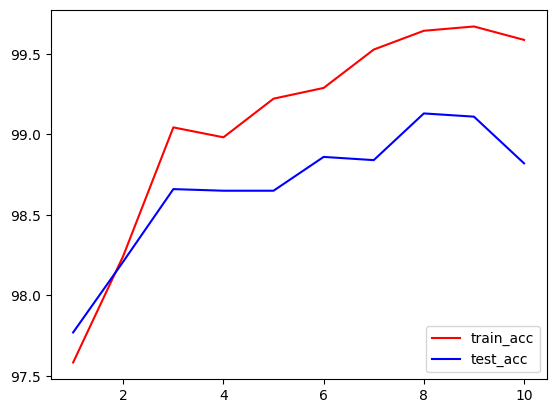

In [ ]:
mnist_model1 = train_model(dataset="MNIST", model_number=1, learning_rate=0.01, max_epoch=10)

data loaded successfully...
[epoch 1, iter   200] loss: 0.928
[epoch 1, iter   400] loss: 0.179
[epoch 1, iter   600] loss: 0.121
[epoch 1, iter   800] loss: 0.091
epoch 1: train_acc 97.828, test_acc 97.720
[epoch 2, iter   200] loss: 0.069
[epoch 2, iter   400] loss: 0.063
[epoch 2, iter   600] loss: 0.057
[epoch 2, iter   800] loss: 0.053
epoch 2: train_acc 98.637, test_acc 98.560
[epoch 3, iter   200] loss: 0.040
[epoch 3, iter   400] loss: 0.044
[epoch 3, iter   600] loss: 0.046
[epoch 3, iter   800] loss: 0.037
epoch 3: train_acc 99.023, test_acc 98.750
[epoch 4, iter   200] loss: 0.028
[epoch 4, iter   400] loss: 0.036
[epoch 4, iter   600] loss: 0.040
[epoch 4, iter   800] loss: 0.032
epoch 4: train_acc 99.278, test_acc 98.770
[epoch 5, iter   200] loss: 0.023
[epoch 5, iter   400] loss: 0.022
[epoch 5, iter   600] loss: 0.029
[epoch 5, iter   800] loss: 0.027
epoch 5: train_acc 99.283, test_acc 98.870
[epoch 6, iter   200] loss: 0.020
[epoch 6, iter   400] loss: 0.020
[epoch 6,

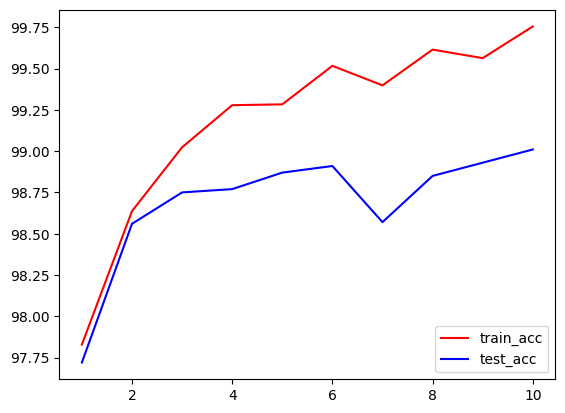

In [ ]:
mnist_model2 = train_model(dataset="MNIST", model_number=2, learning_rate=0.01, max_epoch=10)

data loaded successfully...
[epoch 1, iter   200] loss: 0.875
[epoch 1, iter   400] loss: 0.178
[epoch 1, iter   600] loss: 0.126
[epoch 1, iter   800] loss: 0.101
epoch 1: train_acc 97.518, test_acc 97.490
[epoch 2, iter   200] loss: 0.073
[epoch 2, iter   400] loss: 0.062
[epoch 2, iter   600] loss: 0.067
[epoch 2, iter   800] loss: 0.054
epoch 2: train_acc 98.485, test_acc 98.320
[epoch 3, iter   200] loss: 0.046
[epoch 3, iter   400] loss: 0.045
[epoch 3, iter   600] loss: 0.041
[epoch 3, iter   800] loss: 0.041
epoch 3: train_acc 98.838, test_acc 98.600
[epoch 4, iter   200] loss: 0.032
[epoch 4, iter   400] loss: 0.036
[epoch 4, iter   600] loss: 0.037
[epoch 4, iter   800] loss: 0.033
epoch 4: train_acc 99.217, test_acc 98.750
[epoch 5, iter   200] loss: 0.031
[epoch 5, iter   400] loss: 0.026
[epoch 5, iter   600] loss: 0.025
[epoch 5, iter   800] loss: 0.026
epoch 5: train_acc 99.410, test_acc 98.950
[epoch 6, iter   200] loss: 0.019
[epoch 6, iter   400] loss: 0.025
[epoch 6,

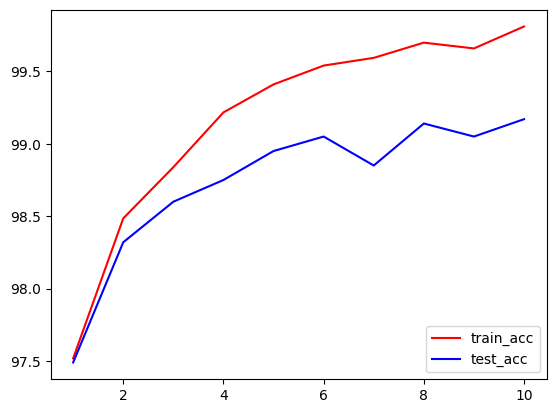

In [ ]:
mnist_model3 = train_model(dataset="MNIST", model_number=3, learning_rate=0.01, max_epoch=10)

data loaded successfully...
[epoch 1, iter   200] loss: 1.083
[epoch 1, iter   400] loss: 0.154
[epoch 1, iter   600] loss: 0.109
[epoch 1, iter   800] loss: 0.092
epoch 1: train_acc 97.927, test_acc 98.070
[epoch 2, iter   200] loss: 0.064
[epoch 2, iter   400] loss: 0.064
[epoch 2, iter   600] loss: 0.059
[epoch 2, iter   800] loss: 0.052
epoch 2: train_acc 98.730, test_acc 98.710
[epoch 3, iter   200] loss: 0.041
[epoch 3, iter   400] loss: 0.044
[epoch 3, iter   600] loss: 0.040
[epoch 3, iter   800] loss: 0.041
epoch 3: train_acc 99.038, test_acc 98.780
[epoch 4, iter   200] loss: 0.030
[epoch 4, iter   400] loss: 0.028
[epoch 4, iter   600] loss: 0.033
[epoch 4, iter   800] loss: 0.037
epoch 4: train_acc 99.010, test_acc 98.590
[epoch 5, iter   200] loss: 0.028
[epoch 5, iter   400] loss: 0.024
[epoch 5, iter   600] loss: 0.028
[epoch 5, iter   800] loss: 0.027
epoch 5: train_acc 99.487, test_acc 99.070
[epoch 6, iter   200] loss: 0.018
[epoch 6, iter   400] loss: 0.021
[epoch 6,

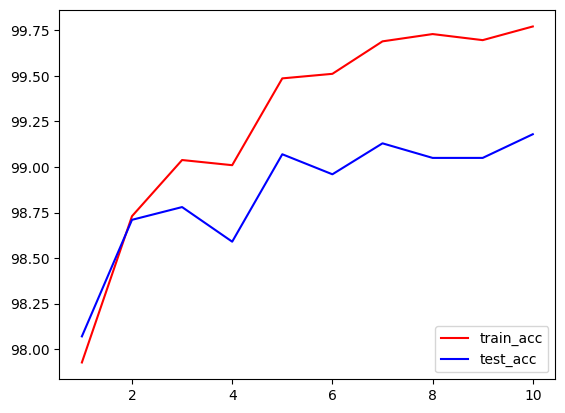

In [ ]:
mnist_model4 = train_model(dataset="MNIST", model_number=4, learning_rate=0.01, max_epoch=10)

data loaded successfully...
[epoch 1, iter   200] loss: 0.870
[epoch 1, iter   400] loss: 0.165
[epoch 1, iter   600] loss: 0.107
[epoch 1, iter   800] loss: 0.094
epoch 1: train_acc 97.463, test_acc 97.420
[epoch 2, iter   200] loss: 0.064
[epoch 2, iter   400] loss: 0.064
[epoch 2, iter   600] loss: 0.062
[epoch 2, iter   800] loss: 0.053
epoch 2: train_acc 98.835, test_acc 98.660
[epoch 3, iter   200] loss: 0.045
[epoch 3, iter   400] loss: 0.039
[epoch 3, iter   600] loss: 0.041
[epoch 3, iter   800] loss: 0.040
epoch 3: train_acc 98.937, test_acc 98.810
[epoch 4, iter   200] loss: 0.028
[epoch 4, iter   400] loss: 0.034
[epoch 4, iter   600] loss: 0.034
[epoch 4, iter   800] loss: 0.027
epoch 4: train_acc 99.338, test_acc 98.850
[epoch 5, iter   200] loss: 0.024
[epoch 5, iter   400] loss: 0.024
[epoch 5, iter   600] loss: 0.027
[epoch 5, iter   800] loss: 0.024
epoch 5: train_acc 99.315, test_acc 98.860
[epoch 6, iter   200] loss: 0.019
[epoch 6, iter   400] loss: 0.021
[epoch 6,

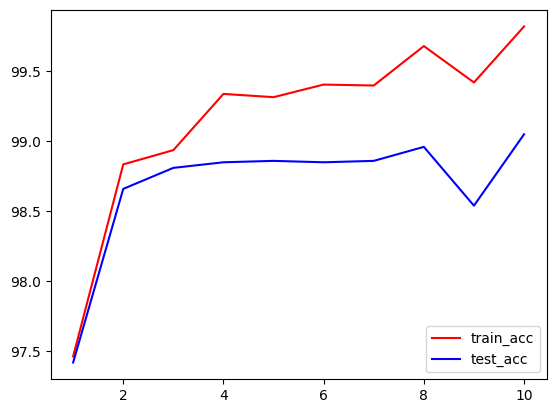

In [ ]:
mnist_model5 = train_model(dataset="MNIST", model_number=5, learning_rate=0.01, max_epoch=10)

data loaded successfully...
[epoch 1, iter   200] loss: 1.260
[epoch 1, iter   400] loss: 0.193
[epoch 1, iter   600] loss: 0.119
[epoch 1, iter   800] loss: 0.109
epoch 1: train_acc 97.947, test_acc 97.840
[epoch 2, iter   200] loss: 0.074
[epoch 2, iter   400] loss: 0.073
[epoch 2, iter   600] loss: 0.061
[epoch 2, iter   800] loss: 0.063
epoch 2: train_acc 98.602, test_acc 98.530
[epoch 3, iter   200] loss: 0.050
[epoch 3, iter   400] loss: 0.044
[epoch 3, iter   600] loss: 0.046
[epoch 3, iter   800] loss: 0.049
epoch 3: train_acc 98.780, test_acc 98.620
[epoch 4, iter   200] loss: 0.035
[epoch 4, iter   400] loss: 0.036
[epoch 4, iter   600] loss: 0.035
[epoch 4, iter   800] loss: 0.037
epoch 4: train_acc 99.212, test_acc 98.780
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.030
[epoch 5, iter   600] loss: 0.031
[epoch 5, iter   800] loss: 0.030
epoch 5: train_acc 99.332, test_acc 98.970
[epoch 6, iter   200] loss: 0.027
[epoch 6, iter   400] loss: 0.021
[epoch 6,

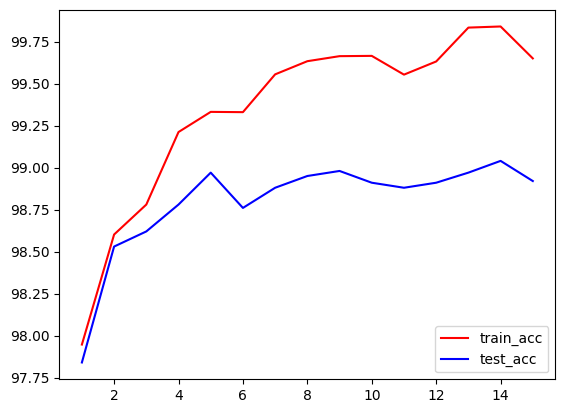

In [ ]:
mnist_model6 = train_model(dataset="MNIST", model_number=6, learning_rate=0.0075, max_epoch=15)

data loaded successfully...
[epoch 1, iter   200] loss: 1.108
[epoch 1, iter   400] loss: 0.190
[epoch 1, iter   600] loss: 0.123
[epoch 1, iter   800] loss: 0.101
epoch 1: train_acc 97.650, test_acc 97.780
[epoch 2, iter   200] loss: 0.073
[epoch 2, iter   400] loss: 0.076
[epoch 2, iter   600] loss: 0.063
[epoch 2, iter   800] loss: 0.058
epoch 2: train_acc 98.572, test_acc 98.570
[epoch 3, iter   200] loss: 0.048
[epoch 3, iter   400] loss: 0.043
[epoch 3, iter   600] loss: 0.053
[epoch 3, iter   800] loss: 0.047
epoch 3: train_acc 98.872, test_acc 98.670
[epoch 4, iter   200] loss: 0.031
[epoch 4, iter   400] loss: 0.037
[epoch 4, iter   600] loss: 0.036
[epoch 4, iter   800] loss: 0.042
epoch 4: train_acc 99.155, test_acc 98.680
[epoch 5, iter   200] loss: 0.030
[epoch 5, iter   400] loss: 0.031
[epoch 5, iter   600] loss: 0.027
[epoch 5, iter   800] loss: 0.026
epoch 5: train_acc 99.265, test_acc 98.700
[epoch 6, iter   200] loss: 0.023
[epoch 6, iter   400] loss: 0.027
[epoch 6,

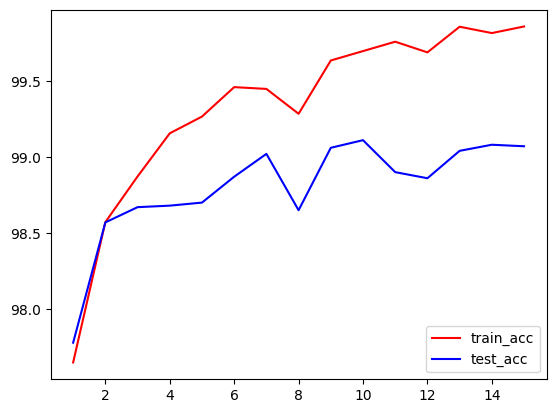

In [ ]:
mnist_model7 = train_model(dataset="MNIST", model_number=7, learning_rate=0.0075, max_epoch=15)

data loaded successfully...
[epoch 1, iter   200] loss: 1.196
[epoch 1, iter   400] loss: 0.208
[epoch 1, iter   600] loss: 0.139
[epoch 1, iter   800] loss: 0.113
epoch 1: train_acc 97.378, test_acc 97.670
[epoch 2, iter   200] loss: 0.081
[epoch 2, iter   400] loss: 0.077
[epoch 2, iter   600] loss: 0.078
[epoch 2, iter   800] loss: 0.067
epoch 2: train_acc 98.512, test_acc 98.460
[epoch 3, iter   200] loss: 0.055
[epoch 3, iter   400] loss: 0.051
[epoch 3, iter   600] loss: 0.056
[epoch 3, iter   800] loss: 0.051
epoch 3: train_acc 98.937, test_acc 98.640
[epoch 4, iter   200] loss: 0.042
[epoch 4, iter   400] loss: 0.039
[epoch 4, iter   600] loss: 0.040
[epoch 4, iter   800] loss: 0.038
epoch 4: train_acc 98.917, test_acc 98.510
[epoch 5, iter   200] loss: 0.028
[epoch 5, iter   400] loss: 0.037
[epoch 5, iter   600] loss: 0.030
[epoch 5, iter   800] loss: 0.033
epoch 5: train_acc 99.128, test_acc 98.670
[epoch 6, iter   200] loss: 0.025
[epoch 6, iter   400] loss: 0.026
[epoch 6,

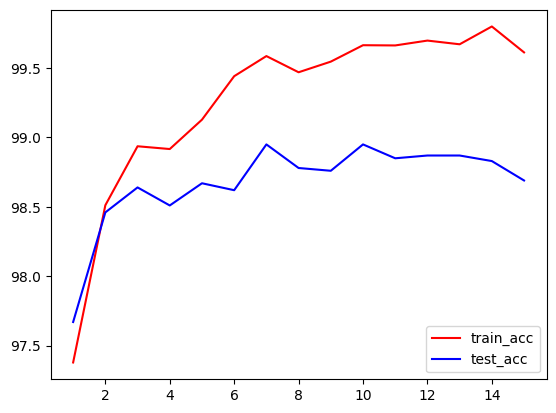

In [ ]:
mnist_model8 = train_model(dataset="MNIST", model_number=8, learning_rate=0.0075, max_epoch=15)

data loaded successfully...
[epoch 1, iter   200] loss: 1.156
[epoch 1, iter   400] loss: 0.206
[epoch 1, iter   600] loss: 0.133
[epoch 1, iter   800] loss: 0.107
epoch 1: train_acc 97.665, test_acc 97.650
[epoch 2, iter   200] loss: 0.074
[epoch 2, iter   400] loss: 0.072
[epoch 2, iter   600] loss: 0.070
[epoch 2, iter   800] loss: 0.060
epoch 2: train_acc 97.940, test_acc 97.890
[epoch 3, iter   200] loss: 0.050
[epoch 3, iter   400] loss: 0.051
[epoch 3, iter   600] loss: 0.046
[epoch 3, iter   800] loss: 0.047
epoch 3: train_acc 99.043, test_acc 98.690
[epoch 4, iter   200] loss: 0.037
[epoch 4, iter   400] loss: 0.036
[epoch 4, iter   600] loss: 0.036
[epoch 4, iter   800] loss: 0.035
epoch 4: train_acc 99.070, test_acc 98.730
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.029
[epoch 5, iter   600] loss: 0.028
[epoch 5, iter   800] loss: 0.028
epoch 5: train_acc 99.275, test_acc 98.900
[epoch 6, iter   200] loss: 0.022
[epoch 6, iter   400] loss: 0.025
[epoch 6,

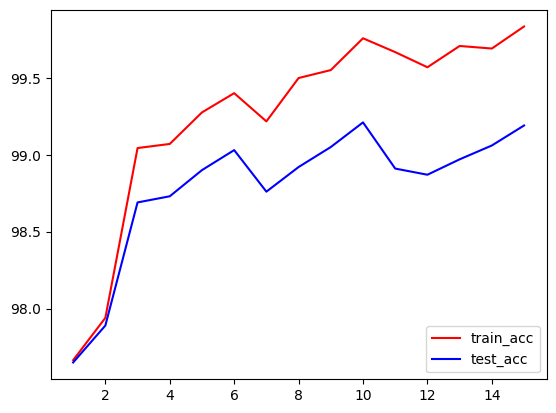

In [ ]:
mnist_model9 = train_model(dataset="MNIST", model_number=9, learning_rate=0.0075, max_epoch=15)

data loaded successfully...
[epoch 1, iter   200] loss: 1.209
[epoch 1, iter   400] loss: 0.197
[epoch 1, iter   600] loss: 0.134
[epoch 1, iter   800] loss: 0.111
epoch 1: train_acc 97.398, test_acc 97.540
[epoch 2, iter   200] loss: 0.080
[epoch 2, iter   400] loss: 0.073
[epoch 2, iter   600] loss: 0.072
[epoch 2, iter   800] loss: 0.063
epoch 2: train_acc 98.682, test_acc 98.410
[epoch 3, iter   200] loss: 0.048
[epoch 3, iter   400] loss: 0.047
[epoch 3, iter   600] loss: 0.054
[epoch 3, iter   800] loss: 0.051
epoch 3: train_acc 98.372, test_acc 98.260
[epoch 4, iter   200] loss: 0.033
[epoch 4, iter   400] loss: 0.034
[epoch 4, iter   600] loss: 0.041
[epoch 4, iter   800] loss: 0.041
epoch 4: train_acc 99.045, test_acc 98.790
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.031
[epoch 5, iter   600] loss: 0.028
[epoch 5, iter   800] loss: 0.033
epoch 5: train_acc 99.217, test_acc 98.700
[epoch 6, iter   200] loss: 0.025
[epoch 6, iter   400] loss: 0.022
[epoch 6,

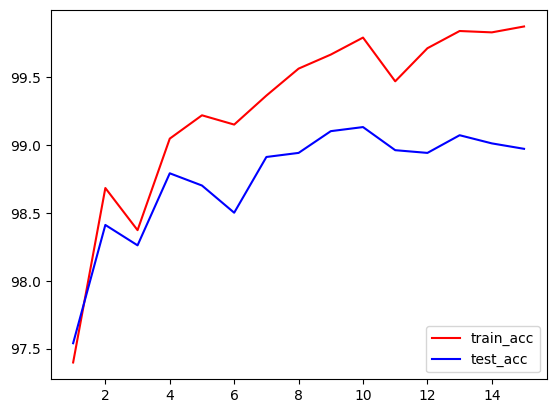

In [ ]:
mnist_model10 = train_model(dataset="MNIST", model_number=10, learning_rate=0.0075, max_epoch=15)

data loaded successfully...
[epoch 1, iter   200] loss: 1.433
[epoch 1, iter   400] loss: 0.260
[epoch 1, iter   600] loss: 0.162
[epoch 1, iter   800] loss: 0.137
epoch 1: train_acc 96.977, test_acc 97.420
[epoch 2, iter   200] loss: 0.091
[epoch 2, iter   400] loss: 0.086
[epoch 2, iter   600] loss: 0.078
[epoch 2, iter   800] loss: 0.077
epoch 2: train_acc 98.252, test_acc 98.360
[epoch 3, iter   200] loss: 0.056
[epoch 3, iter   400] loss: 0.059
[epoch 3, iter   600] loss: 0.057
[epoch 3, iter   800] loss: 0.058
epoch 3: train_acc 98.780, test_acc 98.610
[epoch 4, iter   200] loss: 0.042
[epoch 4, iter   400] loss: 0.042
[epoch 4, iter   600] loss: 0.046
[epoch 4, iter   800] loss: 0.050
epoch 4: train_acc 98.972, test_acc 98.800
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.041
[epoch 5, iter   600] loss: 0.033
[epoch 5, iter   800] loss: 0.036
epoch 5: train_acc 98.815, test_acc 98.470
[epoch 6, iter   200] loss: 0.028
[epoch 6, iter   400] loss: 0.029
[epoch 6,

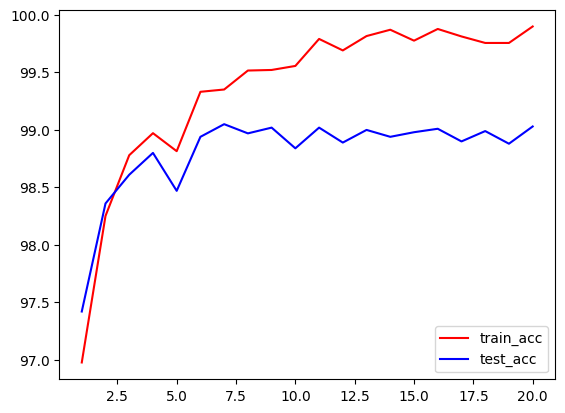

In [ ]:
mnist_model11 = train_model(dataset="MNIST", model_number=11, learning_rate=0.005, max_epoch=20)

data loaded successfully...
[epoch 1, iter   200] loss: 1.528
[epoch 1, iter   400] loss: 0.267
[epoch 1, iter   600] loss: 0.151
[epoch 1, iter   800] loss: 0.113
epoch 1: train_acc 97.277, test_acc 97.240
[epoch 2, iter   200] loss: 0.089
[epoch 2, iter   400] loss: 0.089
[epoch 2, iter   600] loss: 0.074
[epoch 2, iter   800] loss: 0.068
epoch 2: train_acc 98.380, test_acc 98.280
[epoch 3, iter   200] loss: 0.057
[epoch 3, iter   400] loss: 0.054
[epoch 3, iter   600] loss: 0.051
[epoch 3, iter   800] loss: 0.057
epoch 3: train_acc 98.670, test_acc 98.550
[epoch 4, iter   200] loss: 0.042
[epoch 4, iter   400] loss: 0.040
[epoch 4, iter   600] loss: 0.045
[epoch 4, iter   800] loss: 0.048
epoch 4: train_acc 98.885, test_acc 98.530
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.032
[epoch 5, iter   600] loss: 0.042
[epoch 5, iter   800] loss: 0.038
epoch 5: train_acc 98.978, test_acc 98.650
[epoch 6, iter   200] loss: 0.026
[epoch 6, iter   400] loss: 0.030
[epoch 6,

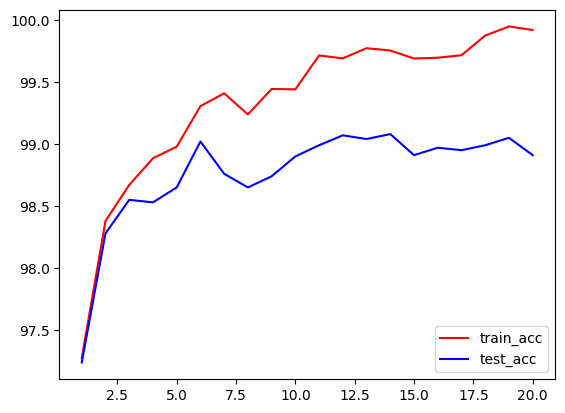

In [ ]:
mnist_model12 = train_model(dataset="MNIST", model_number=12, learning_rate=0.005, max_epoch=20)

data loaded successfully...
[epoch 1, iter   200] loss: 1.401
[epoch 1, iter   400] loss: 0.284
[epoch 1, iter   600] loss: 0.161
[epoch 1, iter   800] loss: 0.118
epoch 1: train_acc 97.345, test_acc 97.630
[epoch 2, iter   200] loss: 0.089
[epoch 2, iter   400] loss: 0.074
[epoch 2, iter   600] loss: 0.069
[epoch 2, iter   800] loss: 0.066
epoch 2: train_acc 98.480, test_acc 98.510
[epoch 3, iter   200] loss: 0.051
[epoch 3, iter   400] loss: 0.056
[epoch 3, iter   600] loss: 0.052
[epoch 3, iter   800] loss: 0.046
epoch 3: train_acc 98.728, test_acc 98.450
[epoch 4, iter   200] loss: 0.043
[epoch 4, iter   400] loss: 0.038
[epoch 4, iter   600] loss: 0.035
[epoch 4, iter   800] loss: 0.047
epoch 4: train_acc 99.112, test_acc 98.810
[epoch 5, iter   200] loss: 0.033
[epoch 5, iter   400] loss: 0.031
[epoch 5, iter   600] loss: 0.031
[epoch 5, iter   800] loss: 0.035
epoch 5: train_acc 99.020, test_acc 98.540
[epoch 6, iter   200] loss: 0.026
[epoch 6, iter   400] loss: 0.027
[epoch 6,

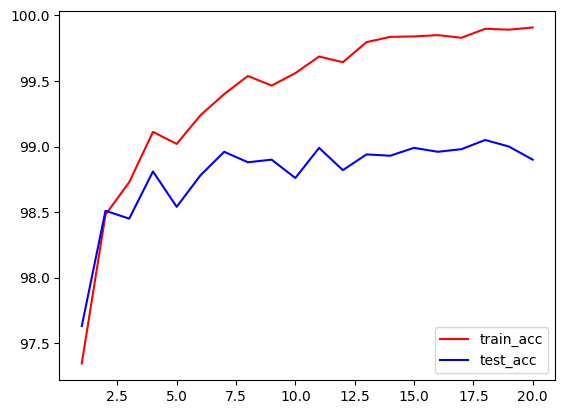

In [ ]:
mnist_model13 = train_model(dataset="MNIST", model_number=13, learning_rate=0.005, max_epoch=20)

data loaded successfully...
[epoch 1, iter   200] loss: 1.390
[epoch 1, iter   400] loss: 0.288
[epoch 1, iter   600] loss: 0.176
[epoch 1, iter   800] loss: 0.126
epoch 1: train_acc 97.353, test_acc 97.220
[epoch 2, iter   200] loss: 0.096
[epoch 2, iter   400] loss: 0.084
[epoch 2, iter   600] loss: 0.083
[epoch 2, iter   800] loss: 0.082
epoch 2: train_acc 97.838, test_acc 97.780
[epoch 3, iter   200] loss: 0.065
[epoch 3, iter   400] loss: 0.052
[epoch 3, iter   600] loss: 0.054
[epoch 3, iter   800] loss: 0.061
epoch 3: train_acc 98.852, test_acc 98.580
[epoch 4, iter   200] loss: 0.043
[epoch 4, iter   400] loss: 0.048
[epoch 4, iter   600] loss: 0.046
[epoch 4, iter   800] loss: 0.052
epoch 4: train_acc 98.637, test_acc 98.420
[epoch 5, iter   200] loss: 0.037
[epoch 5, iter   400] loss: 0.034
[epoch 5, iter   600] loss: 0.041
[epoch 5, iter   800] loss: 0.038
epoch 5: train_acc 99.188, test_acc 98.830
[epoch 6, iter   200] loss: 0.030
[epoch 6, iter   400] loss: 0.028
[epoch 6,

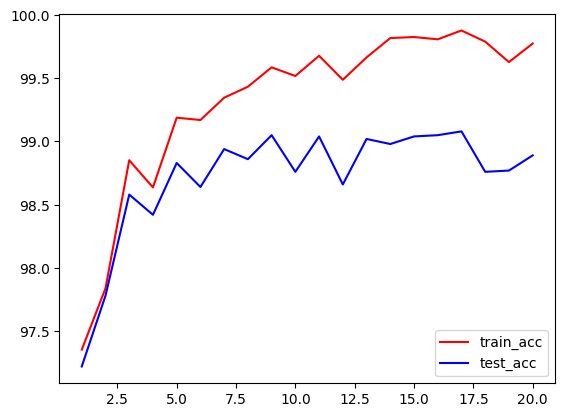

In [ ]:
mnist_model14 = train_model(dataset="MNIST", model_number=14, learning_rate=0.005, max_epoch=20)

data loaded successfully...
[epoch 1, iter   200] loss: 1.300
[epoch 1, iter   400] loss: 0.237
[epoch 1, iter   600] loss: 0.151
[epoch 1, iter   800] loss: 0.111
epoch 1: train_acc 97.268, test_acc 97.450
[epoch 2, iter   200] loss: 0.087
[epoch 2, iter   400] loss: 0.084
[epoch 2, iter   600] loss: 0.075
[epoch 2, iter   800] loss: 0.077
epoch 2: train_acc 98.322, test_acc 98.290
[epoch 3, iter   200] loss: 0.062
[epoch 3, iter   400] loss: 0.053
[epoch 3, iter   600] loss: 0.061
[epoch 3, iter   800] loss: 0.055
epoch 3: train_acc 98.423, test_acc 98.160
[epoch 4, iter   200] loss: 0.037
[epoch 4, iter   400] loss: 0.045
[epoch 4, iter   600] loss: 0.045
[epoch 4, iter   800] loss: 0.047
epoch 4: train_acc 98.518, test_acc 98.130
[epoch 5, iter   200] loss: 0.035
[epoch 5, iter   400] loss: 0.040
[epoch 5, iter   600] loss: 0.039
[epoch 5, iter   800] loss: 0.036
epoch 5: train_acc 98.907, test_acc 98.750
[epoch 6, iter   200] loss: 0.032
[epoch 6, iter   400] loss: 0.028
[epoch 6,

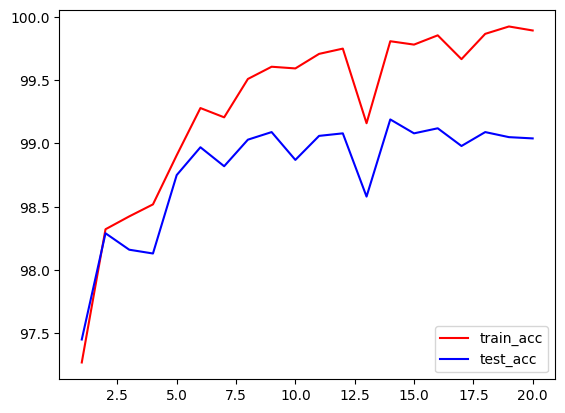

In [ ]:
mnist_model15 = train_model(dataset="MNIST", model_number=15, learning_rate=0.005, max_epoch=20)

In [8]:
def plot_accuracy_over_epoch(train_accuracies, test_accuracies, epochs=10):
    mean_train_accuracies = {
        i: np.mean(train_accuracies[i]) for i in range(1, epochs+1)
    }
    mean_test_accuracies = {
        i: np.mean(test_accuracies[i]) for i in range(1, epochs+1)
    }
    std_train_accuracies = {
        i: np.std(train_accuracies[i]) for i in range(1, epochs+1)
    }
    std_test_accuracies = {
        i: np.std(test_accuracies[i]) for i in range(1, epochs+1)
    }

    mean_train_acc = np.array([mean_train_accuracies[i] for i in range(1, epochs+1)])
    std_train_acc = np.array([std_train_accuracies[i] for i in range(1, epochs+1)])

    mean_test_acc = np.array([mean_test_accuracies[i] for i in range(1, epochs+1)])
    std_test_acc = np.array([std_test_accuracies[i] for i in range(1, epochs+1)])

    epochs_lst = np.arange(1, epochs+1)

    plt.plot(epochs_lst, mean_train_acc, color='blue', label='Mean Training Accuracy')
    plt.fill_between(epochs_lst, mean_train_acc - std_train_acc, mean_train_acc + std_train_acc, color='blue', alpha=0.3)

    plt.plot(epochs_lst, mean_test_acc, color='red', label='Mean Testing Accuracy')
    plt.fill_between(epochs_lst, mean_test_acc - std_test_acc, mean_test_acc + std_test_acc, color='red', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Training & Testing Accuracy')
    plt.legend()
    # Show plot
    plt.grid(True)
    plt.show()

In [9]:
def get_accuracy_maps(accuracies_str, epochs=10):
    accuracy_train_map = {
        i: [] for i in range(1,epochs+1)
    }
    accuracy_test_map = {
        i: [] for i in range(1,epochs+1)
    }
    for line in accuracies_str.split('\n'):
        if line:
            words = line.split()
            epoch = int(words[1][:-1])
            train_acc = float(words[3][:-1])
            test_acc = float(words[5])
            accuracy_train_map[epoch].append(train_acc)
            accuracy_test_map[epoch].append(test_acc)

    return accuracy_train_map, accuracy_test_map

In [10]:
print("MNIST")
print()

# MNIST Settings 1 - LR - 0.01, epochs - 10, momentum - 0.9, train_batch_size 64, test_batch_size - 1000
test_accuracies_1 = [98.820, 99.010, 99.170, 99.180, 99.050]

print("Settings: LR - 0.01, Epochs - 10, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000")
print("Best - ", max(test_accuracies_1))
print("Average - ", sum(test_accuracies_1) / 5)
print()

# MNIST Setting 2 - LR - 0.0075, epochs - 15, momentum - 0.9, train_batch_size 64, test_batch_size - 1000
test_accuracies_2 = [98.920, 99.070, 98.690, 99.190, 98.970]

print("Settings: LR - 0.0075, Epochs - 15, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000")
print("Best - ", max(test_accuracies_2))
print("Average - ", sum(test_accuracies_2) / 5)
print()

# MNIST Setting 3 - LR - 0.005, epochs - 20, momentum - 0.9, train_batch_size 64, test_batch_size - 1000
test_accuracies_3 = [99.030, 98.910, 98.900, 98.890, 99.040]

print("Settings: LR - 0.005, Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000")
print("Best - ", max(test_accuracies_3))
print("Average - ", sum(test_accuracies_3) / 5)

MNIST

Settings: LR - 0.01, Epochs - 10, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000
Best -  99.18
Average -  99.046

Settings: LR - 0.0075, Epochs - 15, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000
Best -  99.19
Average -  98.968

Settings: LR - 0.005, Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000
Best -  99.04
Average -  98.95400000000001


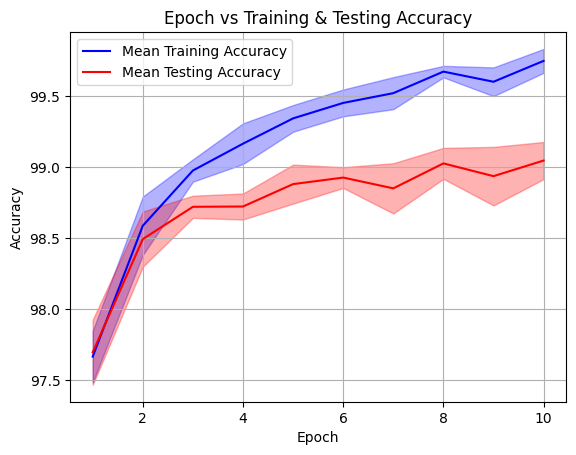

In [ ]:
accuracies_str1 = """
epoch 1: train_acc 97.583, test_acc 97.770
epoch 2: train_acc 98.245, test_acc 98.210
epoch 3: train_acc 99.043, test_acc 98.660
epoch 4: train_acc 98.982, test_acc 98.650
epoch 5: train_acc 99.222, test_acc 98.650
epoch 6: train_acc 99.288, test_acc 98.860
epoch 7: train_acc 99.527, test_acc 98.840
epoch 8: train_acc 99.643, test_acc 99.130
epoch 9: train_acc 99.670, test_acc 99.110
epoch 10: train_acc 99.587, test_acc 98.820

epoch 1: train_acc 97.828, test_acc 97.720
epoch 2: train_acc 98.637, test_acc 98.560
epoch 3: train_acc 99.023, test_acc 98.750
epoch 4: train_acc 99.278, test_acc 98.770
epoch 5: train_acc 99.283, test_acc 98.870
epoch 6: train_acc 99.517, test_acc 98.910
epoch 7: train_acc 99.398, test_acc 98.570
epoch 8: train_acc 99.615, test_acc 98.850
epoch 9: train_acc 99.563, test_acc 98.930
epoch 10: train_acc 99.755, test_acc 99.010

epoch 1: train_acc 97.518, test_acc 97.490
epoch 2: train_acc 98.485, test_acc 98.320
epoch 3: train_acc 98.838, test_acc 98.600
epoch 4: train_acc 99.217, test_acc 98.750
epoch 5: train_acc 99.410, test_acc 98.950
epoch 6: train_acc 99.540, test_acc 99.050
epoch 7: train_acc 99.593, test_acc 98.850
epoch 8: train_acc 99.698, test_acc 99.140
epoch 9: train_acc 99.658, test_acc 99.050
epoch 10: train_acc 99.810, test_acc 99.170

epoch 1: train_acc 97.927, test_acc 98.070
epoch 2: train_acc 98.730, test_acc 98.710
epoch 3: train_acc 99.038, test_acc 98.780
epoch 4: train_acc 99.010, test_acc 98.590
epoch 5: train_acc 99.487, test_acc 99.070
epoch 6: train_acc 99.512, test_acc 98.960
epoch 7: train_acc 99.690, test_acc 99.130
epoch 8: train_acc 99.730, test_acc 99.050
epoch 9: train_acc 99.697, test_acc 99.050
epoch 10: train_acc 99.772, test_acc 99.180

epoch 1: train_acc 97.463, test_acc 97.420
epoch 2: train_acc 98.835, test_acc 98.660
epoch 3: train_acc 98.937, test_acc 98.810
epoch 4: train_acc 99.338, test_acc 98.850
epoch 5: train_acc 99.315, test_acc 98.860
epoch 6: train_acc 99.405, test_acc 98.850
epoch 7: train_acc 99.398, test_acc 98.860
epoch 8: train_acc 99.680, test_acc 98.960
epoch 9: train_acc 99.420, test_acc 98.540
epoch 10: train_acc 99.820, test_acc 99.050
"""

accuracy_train_map1, accuracy_test_map1 = get_accuracy_maps(accuracies_str1, epochs=10)

plot_accuracy_over_epoch(accuracy_train_map1, accuracy_test_map1, epochs=10)

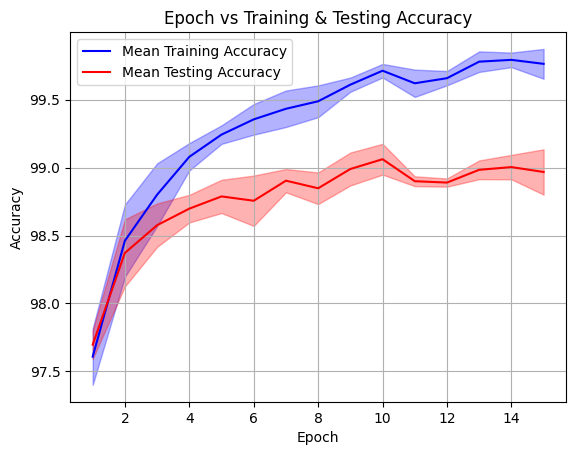

In [ ]:
accuracies_str2 = """
epoch 1: train_acc 97.947, test_acc 97.840
epoch 2: train_acc 98.602, test_acc 98.530
epoch 3: train_acc 98.780, test_acc 98.620
epoch 4: train_acc 99.212, test_acc 98.780
epoch 5: train_acc 99.332, test_acc 98.970
epoch 6: train_acc 99.330, test_acc 98.760
epoch 7: train_acc 99.555, test_acc 98.880
epoch 8: train_acc 99.633, test_acc 98.950
epoch 9: train_acc 99.663, test_acc 98.980
epoch 10: train_acc 99.665, test_acc 98.910
epoch 11: train_acc 99.553, test_acc 98.880
epoch 12: train_acc 99.632, test_acc 98.910
epoch 13: train_acc 99.833, test_acc 98.970
epoch 14: train_acc 99.840, test_acc 99.040
epoch 15: train_acc 99.650, test_acc 98.920

epoch 1: train_acc 97.650, test_acc 97.780
epoch 2: train_acc 98.572, test_acc 98.570
epoch 3: train_acc 98.872, test_acc 98.670
epoch 4: train_acc 99.155, test_acc 98.680
epoch 5: train_acc 99.265, test_acc 98.700
epoch 6: train_acc 99.458, test_acc 98.870
epoch 7: train_acc 99.447, test_acc 99.020
epoch 8: train_acc 99.283, test_acc 98.650
epoch 9: train_acc 99.633, test_acc 99.060
epoch 10: train_acc 99.695, test_acc 99.110
epoch 11: train_acc 99.757, test_acc 98.900
epoch 12: train_acc 99.687, test_acc 98.860
epoch 13: train_acc 99.855, test_acc 99.040
epoch 14: train_acc 99.813, test_acc 99.080
epoch 15: train_acc 99.857, test_acc 99.070

epoch 1: train_acc 97.378, test_acc 97.670
epoch 2: train_acc 98.512, test_acc 98.460
epoch 3: train_acc 98.937, test_acc 98.640
epoch 4: train_acc 98.917, test_acc 98.510
epoch 5: train_acc 99.128, test_acc 98.670
epoch 6: train_acc 99.442, test_acc 98.620
epoch 7: train_acc 99.587, test_acc 98.950
epoch 8: train_acc 99.470, test_acc 98.780
epoch 9: train_acc 99.547, test_acc 98.760
epoch 10: train_acc 99.665, test_acc 98.950
epoch 11: train_acc 99.663, test_acc 98.850
epoch 12: train_acc 99.698, test_acc 98.870
epoch 13: train_acc 99.672, test_acc 98.870
epoch 14: train_acc 99.800, test_acc 98.830
epoch 15: train_acc 99.613, test_acc 98.690

epoch 1: train_acc 97.665, test_acc 97.650
epoch 2: train_acc 97.940, test_acc 97.890
epoch 3: train_acc 99.043, test_acc 98.690
epoch 4: train_acc 99.070, test_acc 98.730
epoch 5: train_acc 99.275, test_acc 98.900
epoch 6: train_acc 99.400, test_acc 99.030
epoch 7: train_acc 99.217, test_acc 98.760
epoch 8: train_acc 99.498, test_acc 98.920
epoch 9: train_acc 99.550, test_acc 99.050
epoch 10: train_acc 99.757, test_acc 99.210
epoch 11: train_acc 99.667, test_acc 98.910
epoch 12: train_acc 99.568, test_acc 98.870
epoch 13: train_acc 99.707, test_acc 98.970
epoch 14: train_acc 99.690, test_acc 99.060
epoch 15: train_acc 99.833, test_acc 99.190

epoch 1: train_acc 97.398, test_acc 97.540
epoch 2: train_acc 98.682, test_acc 98.410
epoch 3: train_acc 98.372, test_acc 98.260
epoch 4: train_acc 99.045, test_acc 98.790
epoch 5: train_acc 99.217, test_acc 98.700
epoch 6: train_acc 99.148, test_acc 98.500
epoch 7: train_acc 99.362, test_acc 98.910
epoch 8: train_acc 99.560, test_acc 98.940
epoch 9: train_acc 99.663, test_acc 99.100
epoch 10: train_acc 99.788, test_acc 99.130
epoch 11: train_acc 99.467, test_acc 98.960
epoch 12: train_acc 99.710, test_acc 98.940
epoch 13: train_acc 99.837, test_acc 99.070
epoch 14: train_acc 99.827, test_acc 99.010
epoch 15: train_acc 99.870, test_acc 98.970
"""

accuracy_train_map2, accuracy_test_map2 = get_accuracy_maps(accuracies_str2, epochs=15)

plot_accuracy_over_epoch(accuracy_train_map2, accuracy_test_map2, epochs=15)

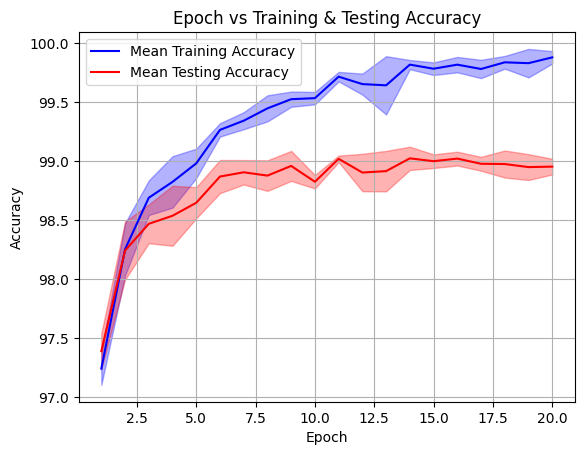

In [ ]:
accuracies_str3 = """
epoch 1: train_acc 96.977, test_acc 97.420
epoch 2: train_acc 98.252, test_acc 98.360
epoch 3: train_acc 98.780, test_acc 98.610
epoch 4: train_acc 98.972, test_acc 98.800
epoch 5: train_acc 98.815, test_acc 98.470
epoch 6: train_acc 99.332, test_acc 98.940
epoch 7: train_acc 99.352, test_acc 99.050
epoch 8: train_acc 99.517, test_acc 98.970
epoch 9: train_acc 99.522, test_acc 99.020
epoch 10: train_acc 99.557, test_acc 98.840
epoch 11: train_acc 99.792, test_acc 99.020
epoch 12: train_acc 99.692, test_acc 98.890
epoch 13: train_acc 99.817, test_acc 99.000
epoch 14: train_acc 99.872, test_acc 98.940
epoch 15: train_acc 99.777, test_acc 98.980
epoch 16: train_acc 99.878, test_acc 99.010
epoch 17: train_acc 99.813, test_acc 98.900
epoch 18: train_acc 99.757, test_acc 98.990
epoch 19: train_acc 99.757, test_acc 98.880
epoch 20: train_acc 99.900, test_acc 99.030

epoch 1: train_acc 97.277, test_acc 97.240
epoch 2: train_acc 98.380, test_acc 98.280
epoch 3: train_acc 98.670, test_acc 98.550
epoch 4: train_acc 98.885, test_acc 98.530
epoch 5: train_acc 98.978, test_acc 98.650
epoch 6: train_acc 99.305, test_acc 99.020
epoch 7: train_acc 99.408, test_acc 98.760
epoch 8: train_acc 99.238, test_acc 98.650
epoch 9: train_acc 99.443, test_acc 98.740
epoch 10: train_acc 99.440, test_acc 98.900
epoch 11: train_acc 99.713, test_acc 98.990
epoch 12: train_acc 99.690, test_acc 99.070
epoch 13: train_acc 99.772, test_acc 99.040
epoch 14: train_acc 99.753, test_acc 99.080
epoch 15: train_acc 99.688, test_acc 98.910
epoch 16: train_acc 99.695, test_acc 98.970
epoch 17: train_acc 99.715, test_acc 98.950
epoch 18: train_acc 99.873, test_acc 98.990
epoch 19: train_acc 99.947, test_acc 99.050
epoch 20: train_acc 99.918, test_acc 98.910

epoch 1: train_acc 97.345, test_acc 97.630
epoch 2: train_acc 98.480, test_acc 98.510
epoch 3: train_acc 98.728, test_acc 98.450
epoch 4: train_acc 99.112, test_acc 98.810
epoch 5: train_acc 99.020, test_acc 98.540
epoch 6: train_acc 99.238, test_acc 98.780
epoch 7: train_acc 99.400, test_acc 98.960
epoch 8: train_acc 99.538, test_acc 98.880
epoch 9: train_acc 99.465, test_acc 98.900
epoch 10: train_acc 99.560, test_acc 98.760
epoch 11: train_acc 99.687, test_acc 98.990
epoch 12: train_acc 99.643, test_acc 98.820
epoch 13: train_acc 99.797, test_acc 98.940
epoch 14: train_acc 99.837, test_acc 98.930
epoch 15: train_acc 99.840, test_acc 98.990
epoch 16: train_acc 99.850, test_acc 98.960
epoch 17: train_acc 99.830, test_acc 98.980
epoch 18: train_acc 99.898, test_acc 99.050
epoch 19: train_acc 99.892, test_acc 99.000
epoch 20: train_acc 99.908, test_acc 98.900

epoch 1: train_acc 97.353, test_acc 97.220
epoch 2: train_acc 97.838, test_acc 97.780
epoch 3: train_acc 98.852, test_acc 98.580
epoch 4: train_acc 98.637, test_acc 98.420
epoch 5: train_acc 99.188, test_acc 98.830
epoch 6: train_acc 99.170, test_acc 98.640
epoch 7: train_acc 99.347, test_acc 98.940
epoch 8: train_acc 99.433, test_acc 98.860
epoch 9: train_acc 99.587, test_acc 99.050
epoch 10: train_acc 99.518, test_acc 98.760
epoch 11: train_acc 99.678, test_acc 99.040
epoch 12: train_acc 99.488, test_acc 98.660
epoch 13: train_acc 99.665, test_acc 99.020
epoch 14: train_acc 99.818, test_acc 98.980
epoch 15: train_acc 99.827, test_acc 99.040
epoch 16: train_acc 99.808, test_acc 99.050
epoch 17: train_acc 99.878, test_acc 99.080
epoch 18: train_acc 99.790, test_acc 98.760
epoch 19: train_acc 99.628, test_acc 98.770
epoch 20: train_acc 99.775, test_acc 98.890

epoch 1: train_acc 97.268, test_acc 97.450
epoch 2: train_acc 98.322, test_acc 98.290
epoch 3: train_acc 98.423, test_acc 98.160
epoch 4: train_acc 98.518, test_acc 98.130
epoch 5: train_acc 98.907, test_acc 98.750
epoch 6: train_acc 99.280, test_acc 98.970
epoch 7: train_acc 99.207, test_acc 98.820
epoch 8: train_acc 99.510, test_acc 99.030
epoch 9: train_acc 99.607, test_acc 99.090
epoch 10: train_acc 99.593, test_acc 98.870
epoch 11: train_acc 99.708, test_acc 99.060
epoch 12: train_acc 99.750, test_acc 99.080
epoch 13: train_acc 99.160, test_acc 98.580
epoch 14: train_acc 99.808, test_acc 99.190
epoch 15: train_acc 99.782, test_acc 99.080
epoch 16: train_acc 99.855, test_acc 99.120
epoch 17: train_acc 99.667, test_acc 98.980
epoch 18: train_acc 99.867, test_acc 99.090
epoch 19: train_acc 99.925, test_acc 99.050
epoch 20: train_acc 99.893, test_acc 99.040
"""

accuracy_train_map3, accuracy_test_map3 = get_accuracy_maps(accuracies_str3, epochs=20)

plot_accuracy_over_epoch(accuracy_train_map3, accuracy_test_map3, epochs=20)

data loaded successfully...
[epoch 1, iter   200] loss: 2.252
[epoch 1, iter   400] loss: 1.296
[epoch 1, iter   600] loss: 0.931
[epoch 1, iter   800] loss: 0.871
[epoch 1, iter  1000] loss: 0.760
[epoch 1, iter  1200] loss: 0.730
[epoch 1, iter  1400] loss: 0.714
[epoch 1, iter  1600] loss: 0.691
[epoch 1, iter  1800] loss: 0.655
epoch 1: train_acc 77.433, test_acc 76.460
[epoch 2, iter   200] loss: 0.601
[epoch 2, iter   400] loss: 0.592
[epoch 2, iter   600] loss: 0.594
[epoch 2, iter   800] loss: 0.568
[epoch 2, iter  1000] loss: 0.552
[epoch 2, iter  1200] loss: 0.526
[epoch 2, iter  1400] loss: 0.525
[epoch 2, iter  1600] loss: 0.513
[epoch 2, iter  1800] loss: 0.494
epoch 2: train_acc 82.400, test_acc 81.080
[epoch 3, iter   200] loss: 0.482
[epoch 3, iter   400] loss: 0.466
[epoch 3, iter   600] loss: 0.454
[epoch 3, iter   800] loss: 0.453
[epoch 3, iter  1000] loss: 0.448
[epoch 3, iter  1200] loss: 0.449
[epoch 3, iter  1400] loss: 0.436
[epoch 3, iter  1600] loss: 0.423
[e

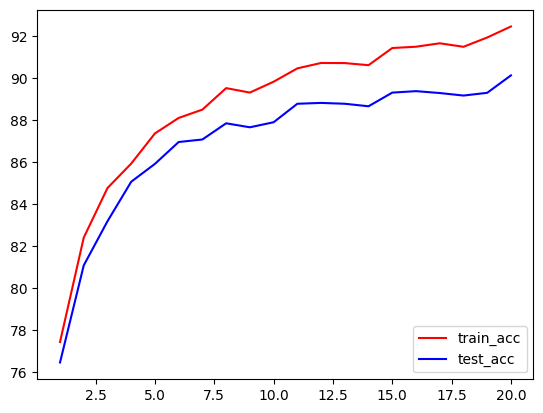

In [ ]:
fashion_mnist_model100 = train_model("FashionMNIST", model_number=100, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

data loaded successfully...
[epoch 1, iter   200] loss: 2.278
[epoch 1, iter   400] loss: 1.559
[epoch 1, iter   600] loss: 0.980
[epoch 1, iter   800] loss: 0.873
[epoch 1, iter  1000] loss: 0.819
[epoch 1, iter  1200] loss: 0.765
[epoch 1, iter  1400] loss: 0.719
[epoch 1, iter  1600] loss: 0.691
[epoch 1, iter  1800] loss: 0.664
epoch 1: train_acc 76.943, test_acc 76.490
[epoch 2, iter   200] loss: 0.626
[epoch 2, iter   400] loss: 0.603
[epoch 2, iter   600] loss: 0.577
[epoch 2, iter   800] loss: 0.593
[epoch 2, iter  1000] loss: 0.581
[epoch 2, iter  1200] loss: 0.549
[epoch 2, iter  1400] loss: 0.540
[epoch 2, iter  1600] loss: 0.532
[epoch 2, iter  1800] loss: 0.503
epoch 2: train_acc 82.643, test_acc 81.710
[epoch 3, iter   200] loss: 0.494
[epoch 3, iter   400] loss: 0.478
[epoch 3, iter   600] loss: 0.457
[epoch 3, iter   800] loss: 0.452
[epoch 3, iter  1000] loss: 0.466
[epoch 3, iter  1200] loss: 0.441
[epoch 3, iter  1400] loss: 0.439
[epoch 3, iter  1600] loss: 0.434
[e

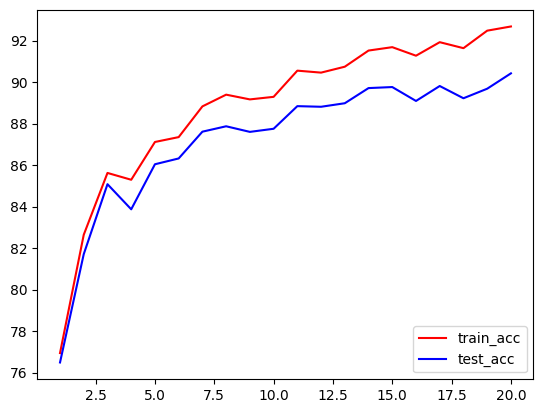

In [ ]:
fashion_mnist_model1 = train_model("FashionMNIST", model_number=1, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

data loaded successfully...
[epoch 1, iter   200] loss: 2.278
[epoch 1, iter   400] loss: 1.590
[epoch 1, iter   600] loss: 0.954
[epoch 1, iter   800] loss: 0.831
[epoch 1, iter  1000] loss: 0.771
[epoch 1, iter  1200] loss: 0.729
[epoch 1, iter  1400] loss: 0.669
[epoch 1, iter  1600] loss: 0.670
[epoch 1, iter  1800] loss: 0.644
epoch 1: train_acc 77.362, test_acc 76.750
[epoch 2, iter   200] loss: 0.603
[epoch 2, iter   400] loss: 0.564
[epoch 2, iter   600] loss: 0.543
[epoch 2, iter   800] loss: 0.541
[epoch 2, iter  1000] loss: 0.534
[epoch 2, iter  1200] loss: 0.511
[epoch 2, iter  1400] loss: 0.484
[epoch 2, iter  1600] loss: 0.503
[epoch 2, iter  1800] loss: 0.469
epoch 2: train_acc 83.475, test_acc 82.570
[epoch 3, iter   200] loss: 0.455
[epoch 3, iter   400] loss: 0.457
[epoch 3, iter   600] loss: 0.443
[epoch 3, iter   800] loss: 0.412
[epoch 3, iter  1000] loss: 0.420
[epoch 3, iter  1200] loss: 0.438
[epoch 3, iter  1400] loss: 0.438
[epoch 3, iter  1600] loss: 0.419
[e

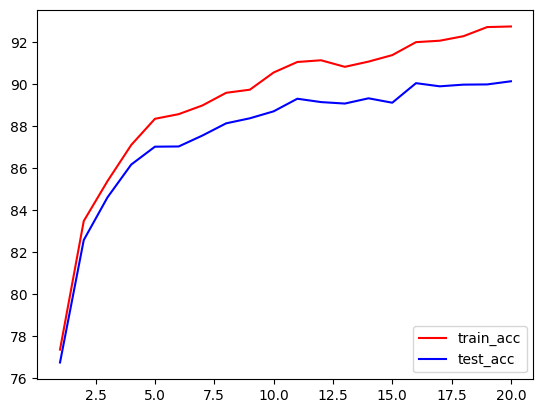

In [ ]:
fashion_mnist_model2 = train_model("FashionMNIST", model_number=2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

data loaded successfully...
[epoch 1, iter   200] loss: 2.292
[epoch 1, iter   400] loss: 1.777
[epoch 1, iter   600] loss: 0.973
[epoch 1, iter   800] loss: 0.849
[epoch 1, iter  1000] loss: 0.775
[epoch 1, iter  1200] loss: 0.736
[epoch 1, iter  1400] loss: 0.717
[epoch 1, iter  1600] loss: 0.645
[epoch 1, iter  1800] loss: 0.643
epoch 1: train_acc 76.005, test_acc 74.830
[epoch 2, iter   200] loss: 0.627
[epoch 2, iter   400] loss: 0.572
[epoch 2, iter   600] loss: 0.562
[epoch 2, iter   800] loss: 0.540
[epoch 2, iter  1000] loss: 0.543
[epoch 2, iter  1200] loss: 0.513
[epoch 2, iter  1400] loss: 0.508
[epoch 2, iter  1600] loss: 0.497
[epoch 2, iter  1800] loss: 0.479
epoch 2: train_acc 82.033, test_acc 81.060
[epoch 3, iter   200] loss: 0.478
[epoch 3, iter   400] loss: 0.448
[epoch 3, iter   600] loss: 0.461
[epoch 3, iter   800] loss: 0.436
[epoch 3, iter  1000] loss: 0.439
[epoch 3, iter  1200] loss: 0.413
[epoch 3, iter  1400] loss: 0.418
[epoch 3, iter  1600] loss: 0.425
[e

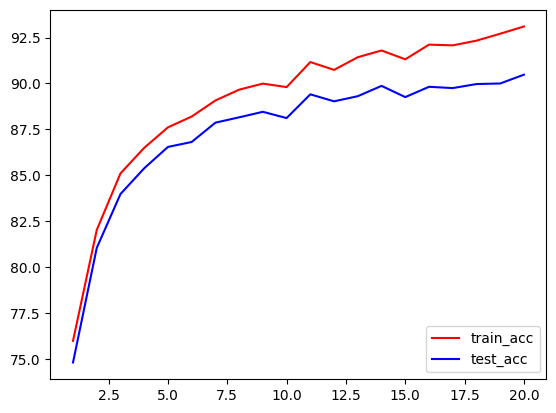

In [ ]:
fashion_mnist_model3 = train_model("FashionMNIST", model_number=3, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

data loaded successfully...
[epoch 1, iter   200] loss: 2.234
[epoch 1, iter   400] loss: 1.212
[epoch 1, iter   600] loss: 0.899
[epoch 1, iter   800] loss: 0.830
[epoch 1, iter  1000] loss: 0.763
[epoch 1, iter  1200] loss: 0.736
[epoch 1, iter  1400] loss: 0.681
[epoch 1, iter  1600] loss: 0.662
[epoch 1, iter  1800] loss: 0.666
epoch 1: train_acc 77.753, test_acc 76.410
[epoch 2, iter   200] loss: 0.614
[epoch 2, iter   400] loss: 0.607
[epoch 2, iter   600] loss: 0.564
[epoch 2, iter   800] loss: 0.556
[epoch 2, iter  1000] loss: 0.536
[epoch 2, iter  1200] loss: 0.518
[epoch 2, iter  1400] loss: 0.529
[epoch 2, iter  1600] loss: 0.516
[epoch 2, iter  1800] loss: 0.491
epoch 2: train_acc 82.887, test_acc 81.990
[epoch 3, iter   200] loss: 0.471
[epoch 3, iter   400] loss: 0.469
[epoch 3, iter   600] loss: 0.464
[epoch 3, iter   800] loss: 0.449
[epoch 3, iter  1000] loss: 0.414
[epoch 3, iter  1200] loss: 0.454
[epoch 3, iter  1400] loss: 0.423
[epoch 3, iter  1600] loss: 0.430
[e

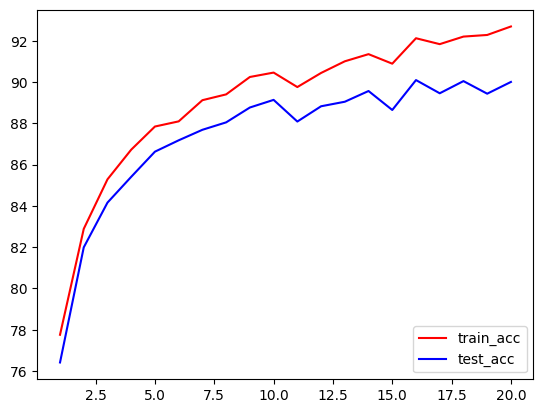

In [ ]:
fashion_mnist_model4 = train_model("FashionMNIST", model_number=4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

In [11]:
# Fashion MNIST Settings - LR - 0.001 epochs 20 momentum 0.9 train_batch_size 32 test_batch_size 256
test_accuracies_fashion = [90.120, 90.420, 90.120, 90.480, 90.010]

print("Settings: LR - 0.001, Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 32, test_batch_size - 256")
print("Best - ", max(test_accuracies_fashion))
print("Average - ", sum(test_accuracies_fashion) / 5)

Settings: LR - 0.001, Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 32, test_batch_size - 256
Best -  90.48
Average -  90.23


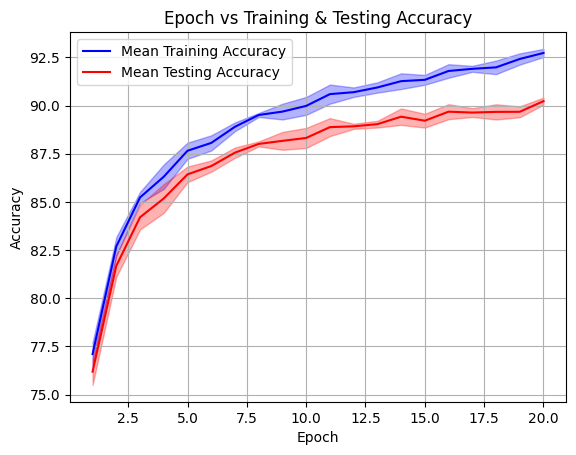

In [ ]:
accuracies_str4="""
epoch 1: train_acc 77.433, test_acc 76.460
epoch 2: train_acc 82.400, test_acc 81.080
epoch 3: train_acc 84.760, test_acc 83.180
epoch 4: train_acc 85.923, test_acc 85.060
epoch 5: train_acc 87.358, test_acc 85.910
epoch 6: train_acc 88.095, test_acc 86.950
epoch 7: train_acc 88.492, test_acc 87.070
epoch 8: train_acc 89.513, test_acc 87.840
epoch 9: train_acc 89.302, test_acc 87.650
epoch 10: train_acc 89.818, test_acc 87.890
epoch 11: train_acc 90.453, test_acc 88.770
epoch 12: train_acc 90.710, test_acc 88.810
epoch 13: train_acc 90.705, test_acc 88.770
epoch 14: train_acc 90.605, test_acc 88.650
epoch 15: train_acc 91.422, test_acc 89.300
epoch 16: train_acc 91.483, test_acc 89.370
epoch 17: train_acc 91.647, test_acc 89.280
epoch 18: train_acc 91.480, test_acc 89.160
epoch 19: train_acc 91.922, test_acc 89.290
epoch 20: train_acc 92.447, test_acc 90.120

epoch 1: train_acc 76.943, test_acc 76.490
epoch 2: train_acc 82.643, test_acc 81.710
epoch 3: train_acc 85.622, test_acc 85.080
epoch 4: train_acc 85.293, test_acc 83.870
epoch 5: train_acc 87.113, test_acc 86.040
epoch 6: train_acc 87.348, test_acc 86.320
epoch 7: train_acc 88.828, test_acc 87.610
epoch 8: train_acc 89.393, test_acc 87.870
epoch 9: train_acc 89.165, test_acc 87.600
epoch 10: train_acc 89.288, test_acc 87.750
epoch 11: train_acc 90.550, test_acc 88.840
epoch 12: train_acc 90.455, test_acc 88.810
epoch 13: train_acc 90.740, test_acc 88.980
epoch 14: train_acc 91.518, test_acc 89.710
epoch 15: train_acc 91.682, test_acc 89.760
epoch 16: train_acc 91.270, test_acc 89.090
epoch 17: train_acc 91.922, test_acc 89.810
epoch 18: train_acc 91.633, test_acc 89.220
epoch 19: train_acc 92.477, test_acc 89.680
epoch 20: train_acc 92.678, test_acc 90.420

epoch 1: train_acc 77.362, test_acc 76.750
epoch 2: train_acc 83.475, test_acc 82.570
epoch 3: train_acc 85.372, test_acc 84.600
epoch 4: train_acc 87.090, test_acc 86.160
epoch 5: train_acc 88.335, test_acc 87.010
epoch 6: train_acc 88.557, test_acc 87.020
epoch 7: train_acc 88.970, test_acc 87.540
epoch 8: train_acc 89.572, test_acc 88.120
epoch 9: train_acc 89.720, test_acc 88.360
epoch 10: train_acc 90.537, test_acc 88.690
epoch 11: train_acc 91.037, test_acc 89.290
epoch 12: train_acc 91.118, test_acc 89.130
epoch 13: train_acc 90.807, test_acc 89.060
epoch 14: train_acc 91.055, test_acc 89.310
epoch 15: train_acc 91.363, test_acc 89.100
epoch 16: train_acc 91.980, test_acc 90.030
epoch 17: train_acc 92.048, test_acc 89.880
epoch 18: train_acc 92.263, test_acc 89.960
epoch 19: train_acc 92.697, test_acc 89.970
epoch 20: train_acc 92.725, test_acc 90.120

epoch 1: train_acc 76.005, test_acc 74.830
epoch 2: train_acc 82.033, test_acc 81.060
epoch 3: train_acc 85.112, test_acc 83.990
epoch 4: train_acc 86.502, test_acc 85.390
epoch 5: train_acc 87.615, test_acc 86.550
epoch 6: train_acc 88.203, test_acc 86.820
epoch 7: train_acc 89.077, test_acc 87.870
epoch 8: train_acc 89.665, test_acc 88.160
epoch 9: train_acc 89.993, test_acc 88.460
epoch 10: train_acc 89.803, test_acc 88.120
epoch 11: train_acc 91.165, test_acc 89.410
epoch 12: train_acc 90.740, test_acc 89.030
epoch 13: train_acc 91.430, test_acc 89.310
epoch 14: train_acc 91.795, test_acc 89.870
epoch 15: train_acc 91.315, test_acc 89.260
epoch 16: train_acc 92.113, test_acc 89.820
epoch 17: train_acc 92.073, test_acc 89.750
epoch 18: train_acc 92.328, test_acc 89.970
epoch 19: train_acc 92.707, test_acc 90.000
epoch 20: train_acc 93.100, test_acc 90.480

epoch 1: train_acc 77.753, test_acc 76.410
epoch 2: train_acc 82.887, test_acc 81.990
epoch 3: train_acc 85.288, test_acc 84.160
epoch 4: train_acc 86.727, test_acc 85.410
epoch 5: train_acc 87.848, test_acc 86.630
epoch 6: train_acc 88.098, test_acc 87.180
epoch 7: train_acc 89.125, test_acc 87.690
epoch 8: train_acc 89.407, test_acc 88.050
epoch 9: train_acc 90.250, test_acc 88.770
epoch 10: train_acc 90.463, test_acc 89.140
epoch 11: train_acc 89.762, test_acc 88.090
epoch 12: train_acc 90.445, test_acc 88.830
epoch 13: train_acc 91.010, test_acc 89.050
epoch 14: train_acc 91.357, test_acc 89.570
epoch 15: train_acc 90.895, test_acc 88.650
epoch 16: train_acc 92.128, test_acc 90.100
epoch 17: train_acc 91.842, test_acc 89.460
epoch 18: train_acc 92.208, test_acc 90.050
epoch 19: train_acc 92.287, test_acc 89.440
epoch 20: train_acc 92.698, test_acc 90.010
"""

accuracy_train_map4, accuracy_test_map4 = get_accuracy_maps(accuracies_str4, epochs=20)

plot_accuracy_over_epoch(accuracy_train_map4, accuracy_test_map4, epochs=20)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.164
[epoch 1, iter   400] loss: 1.854
[epoch 1, iter   600] loss: 1.652
epoch 1: train_acc 42.890, test_acc 42.630
[epoch 2, iter   200] loss: 1.492
[epoch 2, iter   400] loss: 1.465
[epoch 2, iter   600] loss: 1.422
epoch 2: train_acc 52.500, test_acc 51.500
[epoch 3, iter   200] loss: 1.347
[epoch 3, iter   400] loss: 1.319
[epoch 3, iter   600] loss: 1.284
epoch 3: train_acc 54.162, test_acc 52.280
[epoch 4, iter   200] loss: 1.239
[epoch 4, iter   400] loss: 1.209
[epoch 4, iter   600] loss: 1.214
epoch 4: train_acc 61.460, test_acc 57.540
[epoch 5, iter   200] loss: 1.139
[epoch 5, iter   400] loss: 1.139
[epoch 5, iter   600] loss: 1.136
epoch 5: train_acc 60.838, test_acc 56.340
[epoch 6, iter   200] loss: 1.066
[epoch 6, iter   400] loss: 1.078
[epoch 6, iter   600] loss: 1.068
epoch 6: train_acc 63.584, test_acc 58.320
[epoch 7, iter   200] loss

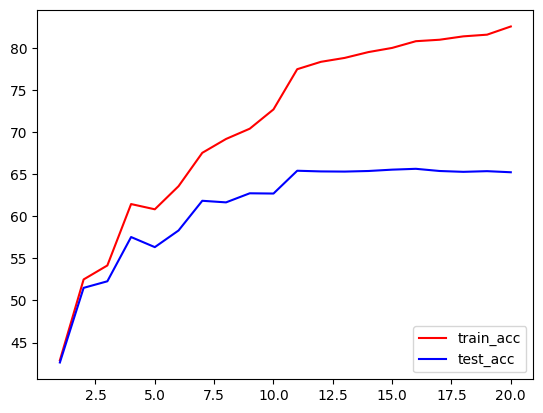

In [ ]:
cifar10_model14 = train_model("CIFAR10", num_channels=3, model_number=14, learning_rate=0.008, max_epoch=20, add_scheduler=True, decay=0.1, step_size=10)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.206
[epoch 1, iter   400] loss: 1.852
[epoch 1, iter   600] loss: 1.657
epoch 1: train_acc 41.956, test_acc 42.270
[epoch 2, iter   200] loss: 1.479
[epoch 2, iter   400] loss: 1.445
[epoch 2, iter   600] loss: 1.418
epoch 2: train_acc 52.014, test_acc 50.360
[epoch 3, iter   200] loss: 1.351
[epoch 3, iter   400] loss: 1.323
[epoch 3, iter   600] loss: 1.288
epoch 3: train_acc 55.430, test_acc 52.960
[epoch 4, iter   200] loss: 1.209
[epoch 4, iter   400] loss: 1.211
[epoch 4, iter   600] loss: 1.179
epoch 4: train_acc 55.992, test_acc 53.770
[epoch 5, iter   200] loss: 1.110
[epoch 5, iter   400] loss: 1.142
[epoch 5, iter   600] loss: 1.120
epoch 5: train_acc 63.472, test_acc 59.430
[epoch 6, iter   200] loss: 1.039
[epoch 6, iter   400] loss: 1.064
[epoch 6, iter   600] loss: 1.068
epoch 6: train_acc 65.922, test_acc 61.220
[epoch 7, iter   200] loss

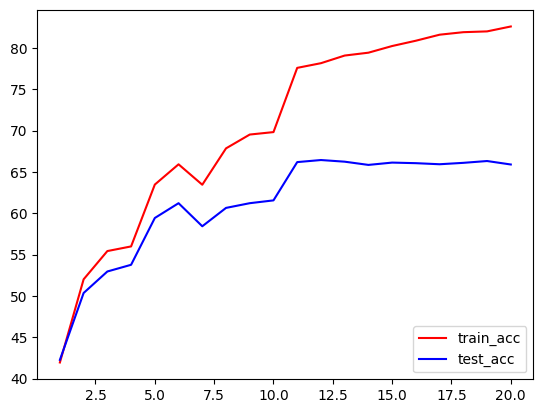

In [ ]:
cifar10_model14 = train_model("CIFAR10", num_channels=3, model_number=14, learning_rate=0.008, max_epoch=20, add_scheduler=True, decay=0.1, step_size=10)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.231
[epoch 1, iter   400] loss: 1.908
[epoch 1, iter   600] loss: 1.675
epoch 1: train_acc 45.314, test_acc 45.010
[epoch 2, iter   200] loss: 1.520
[epoch 2, iter   400] loss: 1.462
[epoch 2, iter   600] loss: 1.413
epoch 2: train_acc 52.596, test_acc 51.310
[epoch 3, iter   200] loss: 1.329
[epoch 3, iter   400] loss: 1.334
[epoch 3, iter   600] loss: 1.280
epoch 3: train_acc 54.686, test_acc 52.390
[epoch 4, iter   200] loss: 1.221
[epoch 4, iter   400] loss: 1.207
[epoch 4, iter   600] loss: 1.182
epoch 4: train_acc 60.902, test_acc 58.160
[epoch 5, iter   200] loss: 1.119
[epoch 5, iter   400] loss: 1.130
[epoch 5, iter   600] loss: 1.148
epoch 5: train_acc 62.558, test_acc 58.550
[epoch 6, iter   200] loss: 1.031
[epoch 6, iter   400] loss: 1.066
[epoch 6, iter   600] loss: 1.059
epoch 6: train_acc 65.140, test_acc 59.330
[epoch 7, iter   200] loss

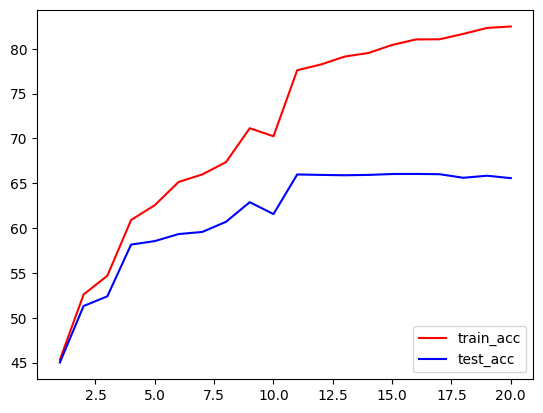

In [ ]:
cifar10_model19 = train_model("CIFAR10", num_channels=3, model_number=19, learning_rate=0.008, max_epoch=20, add_scheduler=True, decay=0.1, step_size=10)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.243
[epoch 1, iter   400] loss: 1.915
[epoch 1, iter   600] loss: 1.652
epoch 1: train_acc 45.148, test_acc 44.380
[epoch 2, iter   200] loss: 1.500
[epoch 2, iter   400] loss: 1.488
[epoch 2, iter   600] loss: 1.439
epoch 2: train_acc 50.044, test_acc 48.750
[epoch 3, iter   200] loss: 1.343
[epoch 3, iter   400] loss: 1.312
[epoch 3, iter   600] loss: 1.298
epoch 3: train_acc 54.214, test_acc 52.460
[epoch 4, iter   200] loss: 1.235
[epoch 4, iter   400] loss: 1.220
[epoch 4, iter   600] loss: 1.209
epoch 4: train_acc 58.614, test_acc 55.800
[epoch 5, iter   200] loss: 1.157
[epoch 5, iter   400] loss: 1.145
[epoch 5, iter   600] loss: 1.149
epoch 5: train_acc 59.902, test_acc 56.340
[epoch 6, iter   200] loss: 1.080
[epoch 6, iter   400] loss: 1.072
[epoch 6, iter   600] loss: 1.085
epoch 6: train_acc 64.702, test_acc 60.390
[epoch 7, iter   200] loss

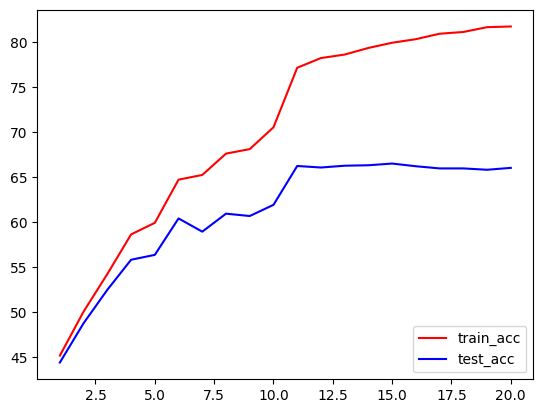

In [ ]:
cifar10_model21 = train_model("CIFAR10", num_channels=3, model_number=21, learning_rate=0.008, max_epoch=20, add_scheduler=True, decay=0.1, step_size=10)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
[epoch 1, iter   200] loss: 2.227
[epoch 1, iter   400] loss: 1.995
[epoch 1, iter   600] loss: 1.758
epoch 1: train_acc 43.328, test_acc 42.900
[epoch 2, iter   200] loss: 1.506
[epoch 2, iter   400] loss: 1.444
[epoch 2, iter   600] loss: 1.408
epoch 2: train_acc 50.590, test_acc 50.260
[epoch 3, iter   200] loss: 1.299
[epoch 3, iter   400] loss: 1.297
[epoch 3, iter   600] loss: 1.263
epoch 3: train_acc 58.850, test_acc 56.040
[epoch 4, iter   200] loss: 1.192
[epoch 4, iter   400] loss: 1.172
[epoch 4, iter   600] loss: 1.171
epoch 4: train_acc 60.424, test_acc 57.400
[epoch 5, iter   200] loss: 1.090
[epoch 5, iter   400] loss: 1.087
[epoch 5, iter   600] loss: 1.100
epoch 5: train_acc 62.950, test_acc 58.470
[epoch 6, iter   200] loss: 1.033
[epoch 6, iter   400] loss: 1.029
[epoch 6, iter   600] loss: 1.038
epoch 6: train_acc 67.382, test_acc 62.150
[epoch 7, iter   200] loss

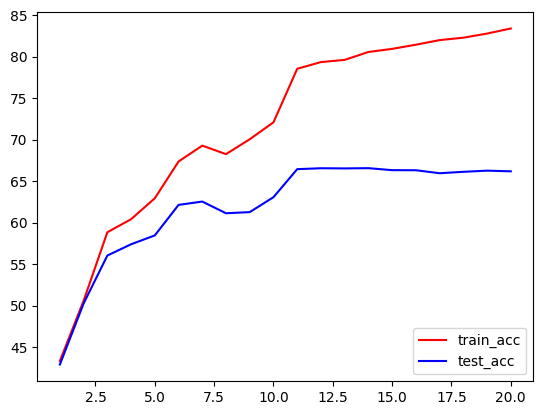

In [ ]:
cifar10_model39 = train_model("CIFAR10", num_channels=3, model_number=39, learning_rate=0.008, max_epoch=20, add_scheduler=True, decay=0.1, step_size=10)

In [ ]:
# CIFAR10 MNIST Settings - epochs 20 momentum 0.9 LR - 0.008 Step LR step size 10 gamma 0.1
cifar10_accuracies = [65.24,65.9,65.57,66.01,66.20]

print("Settings: Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000, LR - 0.005, StepLR, Step Size - 10, Gamma 0.1")
print("Best - ", max(cifar10_accuracies))
print("Average - ", sum(cifar10_accuracies) / 5)

Settings: Epochs - 20, Optimizer - SGD, Momentum - 0.9, train_batch_size 64, test_batch_size - 1000, LR - 0.005, StepLR, Step Size - 10, Gamma 0.1
Best -  66.2
Average -  65.78399999999999


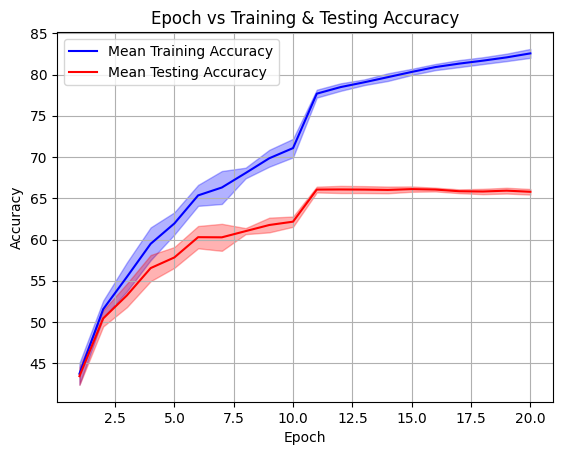

In [ ]:
accuracies_str5="""
epoch 1: train_acc 42.890, test_acc 42.630
epoch 2: train_acc 52.500, test_acc 51.500
epoch 3: train_acc 54.162, test_acc 52.280
epoch 4: train_acc 61.460, test_acc 57.540
epoch 5: train_acc 60.838, test_acc 56.340
epoch 6: train_acc 63.584, test_acc 58.320
epoch 7: train_acc 67.550, test_acc 61.850
epoch 8: train_acc 69.196, test_acc 61.660
epoch 9: train_acc 70.418, test_acc 62.740
epoch 10: train_acc 72.710, test_acc 62.710
epoch 11: train_acc 77.490, test_acc 65.420
epoch 12: train_acc 78.368, test_acc 65.340
epoch 13: train_acc 78.832, test_acc 65.320
epoch 14: train_acc 79.524, test_acc 65.390
epoch 15: train_acc 80.020, test_acc 65.550
epoch 16: train_acc 80.818, test_acc 65.650
epoch 17: train_acc 80.992, test_acc 65.390
epoch 18: train_acc 81.394, test_acc 65.290
epoch 19: train_acc 81.594, test_acc 65.370
epoch 20: train_acc 82.568, test_acc 65.240

epoch 1: train_acc 41.956, test_acc 42.270
epoch 2: train_acc 52.014, test_acc 50.360
epoch 3: train_acc 55.430, test_acc 52.960
epoch 4: train_acc 55.992, test_acc 53.770
epoch 5: train_acc 63.472, test_acc 59.430
epoch 6: train_acc 65.922, test_acc 61.220
epoch 7: train_acc 63.452, test_acc 58.430
epoch 8: train_acc 67.850, test_acc 60.650
epoch 9: train_acc 69.522, test_acc 61.220
epoch 10: train_acc 69.818, test_acc 61.560
epoch 11: train_acc 77.586, test_acc 66.190
epoch 12: train_acc 78.152, test_acc 66.440
epoch 13: train_acc 79.076, test_acc 66.240
epoch 14: train_acc 79.422, test_acc 65.850
epoch 15: train_acc 80.228, test_acc 66.130
epoch 16: train_acc 80.870, test_acc 66.060
epoch 17: train_acc 81.598, test_acc 65.930
epoch 18: train_acc 81.902, test_acc 66.100
epoch 19: train_acc 81.998, test_acc 66.320
epoch 20: train_acc 82.592, test_acc 65.900

epoch 1: train_acc 45.314, test_acc 45.010
epoch 2: train_acc 52.596, test_acc 51.310
epoch 3: train_acc 54.686, test_acc 52.390
epoch 4: train_acc 60.902, test_acc 58.160
epoch 5: train_acc 62.558, test_acc 58.550
epoch 6: train_acc 65.140, test_acc 59.330
epoch 7: train_acc 65.984, test_acc 59.570
epoch 8: train_acc 67.360, test_acc 60.700
epoch 9: train_acc 71.138, test_acc 62.890
epoch 10: train_acc 70.240, test_acc 61.560
epoch 11: train_acc 77.606, test_acc 65.980
epoch 12: train_acc 78.248, test_acc 65.930
epoch 13: train_acc 79.130, test_acc 65.890
epoch 14: train_acc 79.528, test_acc 65.930
epoch 15: train_acc 80.426, test_acc 66.030
epoch 16: train_acc 81.038, test_acc 66.040
epoch 17: train_acc 81.060, test_acc 66.010
epoch 18: train_acc 81.660, test_acc 65.610
epoch 19: train_acc 82.324, test_acc 65.840
epoch 20: train_acc 82.486, test_acc 65.570

epoch 1: train_acc 45.148, test_acc 44.380
epoch 2: train_acc 50.044, test_acc 48.750
epoch 3: train_acc 54.214, test_acc 52.460
epoch 4: train_acc 58.614, test_acc 55.800
epoch 5: train_acc 59.902, test_acc 56.340
epoch 6: train_acc 64.702, test_acc 60.390
epoch 7: train_acc 65.224, test_acc 58.920
epoch 8: train_acc 67.596, test_acc 60.920
epoch 9: train_acc 68.096, test_acc 60.660
epoch 10: train_acc 70.522, test_acc 61.900
epoch 11: train_acc 77.138, test_acc 66.220
epoch 12: train_acc 78.216, test_acc 66.050
epoch 13: train_acc 78.606, test_acc 66.250
epoch 14: train_acc 79.340, test_acc 66.300
epoch 15: train_acc 79.918, test_acc 66.490
epoch 16: train_acc 80.316, test_acc 66.190
epoch 17: train_acc 80.920, test_acc 65.950
epoch 18: train_acc 81.114, test_acc 65.950
epoch 19: train_acc 81.648, test_acc 65.800
epoch 20: train_acc 81.726, test_acc 66.010

epoch 1: train_acc 43.328, test_acc 42.900
epoch 2: train_acc 50.590, test_acc 50.260
epoch 3: train_acc 58.850, test_acc 56.040
epoch 4: train_acc 60.424, test_acc 57.400
epoch 5: train_acc 62.950, test_acc 58.470
epoch 6: train_acc 67.382, test_acc 62.150
epoch 7: train_acc 69.300, test_acc 62.550
epoch 8: train_acc 68.274, test_acc 61.140
epoch 9: train_acc 70.068, test_acc 61.280
epoch 10: train_acc 72.110, test_acc 63.080
epoch 11: train_acc 78.568, test_acc 66.460
epoch 12: train_acc 79.376, test_acc 66.570
epoch 13: train_acc 79.644, test_acc 66.550
epoch 14: train_acc 80.596, test_acc 66.580
epoch 15: train_acc 80.970, test_acc 66.340
epoch 16: train_acc 81.472, test_acc 66.330
epoch 17: train_acc 82.026, test_acc 65.970
epoch 18: train_acc 82.320, test_acc 66.140
epoch 19: train_acc 82.814, test_acc 66.280
epoch 20: train_acc 83.430, test_acc 66.200
"""

accuracy_train_map5, accuracy_test_map5 = get_accuracy_maps(accuracies_str5, epochs=20)

plot_accuracy_over_epoch(accuracy_train_map5, accuracy_test_map5, epochs=20)

In [43]:
def find_confusing_images(test_loader, preds, labels, class_names, n_images=3, num_channels=1):
    misclassified = preds != labels
    misclassified_indices = np.where(misclassified.cpu())[0]

    # Extract misclassified labels and predictions
    misclassified_labels = labels[misclassified].cpu().numpy()
    misclassified_preds = preds[misclassified].cpu().numpy()

    # Compute unique misclassification pairs (true label, predicted label) and their counts
    misclassification_pairs = list(zip(misclassified_labels, misclassified_preds))
    pair_counts = Counter(misclassification_pairs)
    most_common_pairs = pair_counts.most_common(n_images)

    confusing_images = []
    confusing_labels = []
    confusing_preds = []

    # Find an example image for each of the most common misclassification pairs
    for (true_label, pred_label), _ in most_common_pairs:
        for idx in misclassified_indices:
            if labels[idx].cpu().item() == true_label and preds[idx].cpu().item() == pred_label:
                confusing_images.append(test_loader.dataset[idx][0])
                confusing_labels.append(true_label)
                confusing_preds.append(pred_label)
                break

    plt.figure(figsize=(12, 4))
    for i, (image, true_label, pred_label) in enumerate(zip(confusing_images, confusing_labels, confusing_preds)):
        plt.subplot(1, len(confusing_images), i + 1)
        if num_channels==1:
            plt.imshow(image.squeeze(), cmap='gray')
        else:
            image = image.permute(1, 2, 0)
            image = image.clip(0, 1)
            plt.imshow(image)
        # Convert labels to integers explicitly
        true_label_int = int(true_label)
        pred_label_int = int(pred_label)
        plt.title(f'True: {class_names[true_label_int]}, Pred: {class_names[pred_label_int]}')
        plt.axis('off')
    plt.show()

In [24]:
def get_prediction_probabilites(model, x):
    model.eval()
    actual = []
    predictions = []
    with torch.no_grad():
        correct = 0
        total = 0

        for data in x:
            images, labels = data

            images, labels = images, labels

            outputs = model(images)

            actual.append(labels)
            predictions.append(outputs)

    return torch.cat(actual, dim=0), torch.cat(predictions, dim=0)

data loaded successfully...


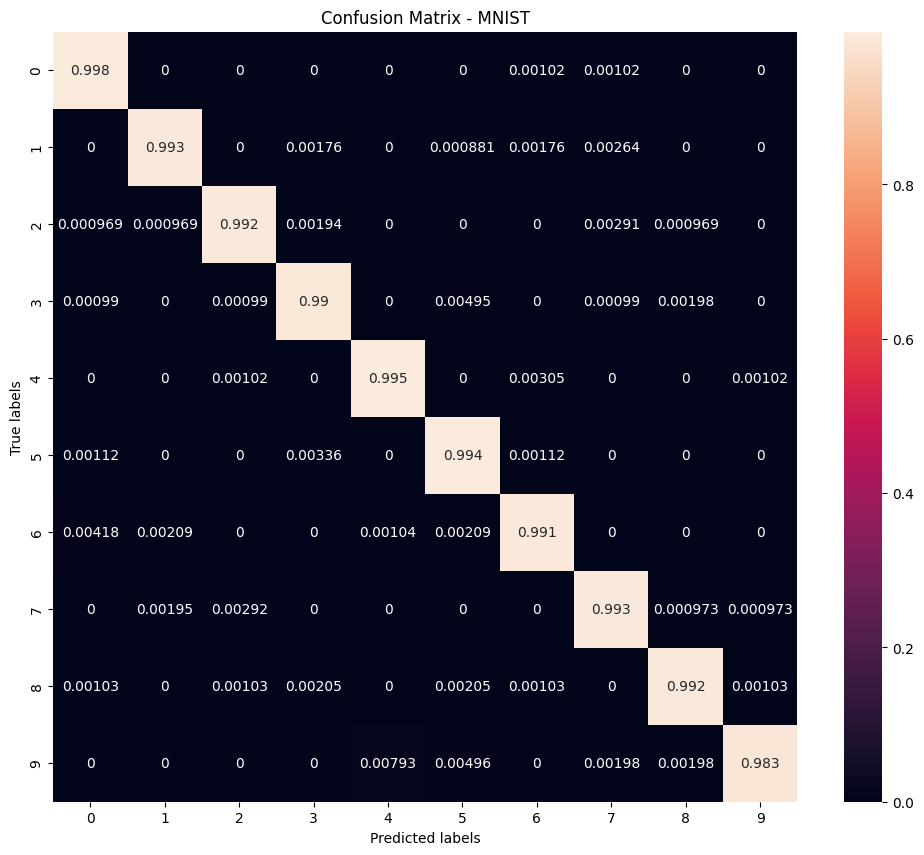

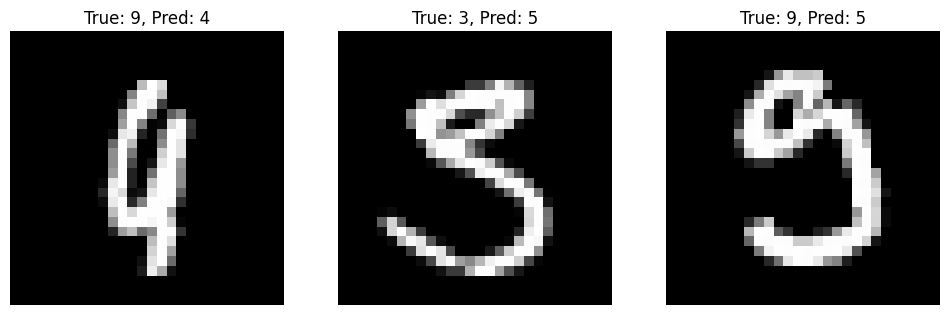

In [34]:
mnist_model_path = base_path + "MNIST_9_99.21.pt"
mnist_model = Net()
mnist_model.load_state_dict(torch.load(mnist_model_path))

_, test_loader = load_data("MNIST")

y_actual, y_pred_probabilities = get_prediction_probabilites(mnist_model, test_loader)
y_pred = torch.argmax(y_pred_probabilities, dim=1)

cm = confusion_matrix(y_actual, y_pred, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".3g")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - MNIST')
plt.show()

print()
print()
find_confusing_images(test_loader, y_pred, y_actual, class_names=[i for i in range(10)])

data loaded successfully...


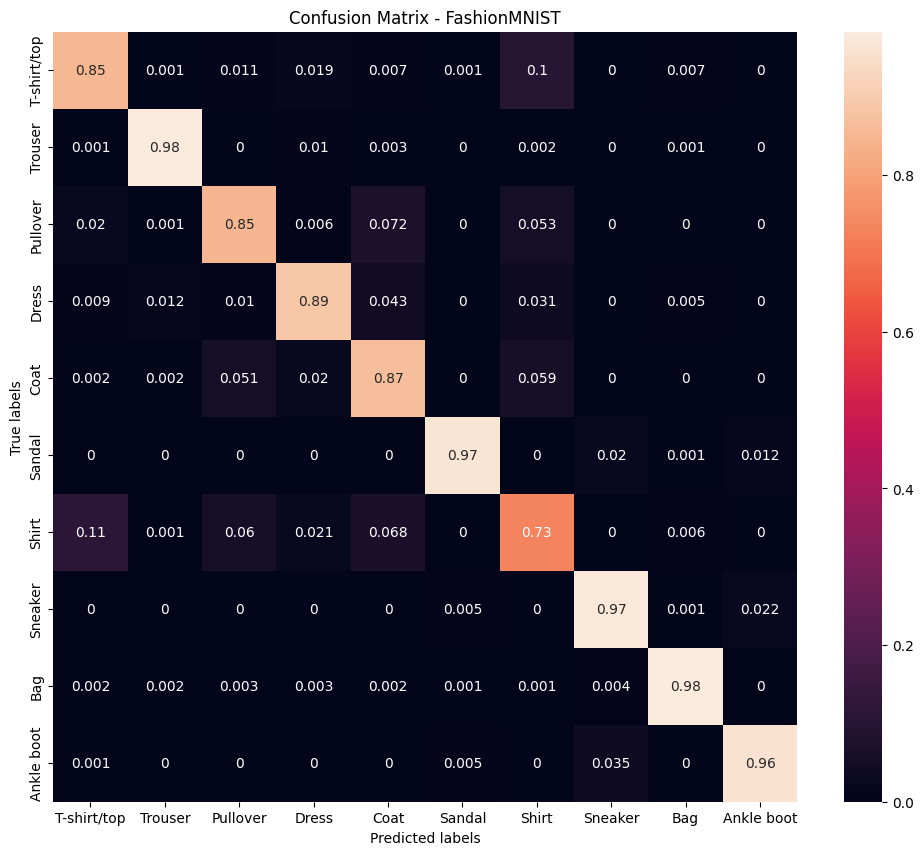

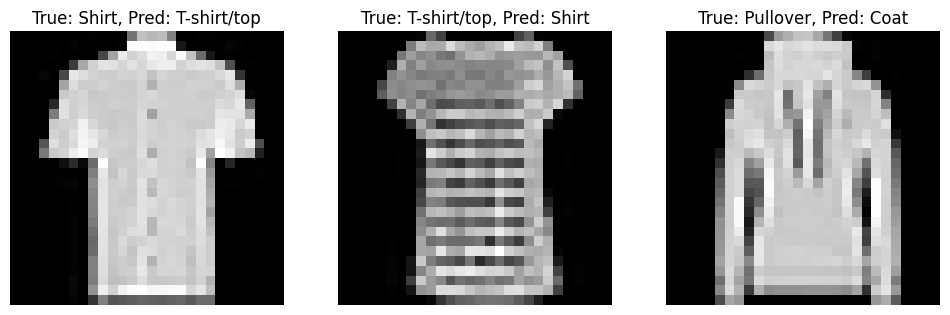

In [35]:
fashion_mnist_model_path = base_path + "FashionMNIST_3_90.48.pt"
fashion_mnist_model = Net()
fashion_mnist_model.load_state_dict(torch.load(fashion_mnist_model_path))

_, test_loader = load_data("FashionMNIST")


y_actual, y_pred_probabilities = get_prediction_probabilites(fashion_mnist_model, test_loader)

y_pred = torch.argmax(y_pred_probabilities, dim=1)

cm = confusion_matrix(y_actual, y_pred, normalize='true')
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - FashionMNIST')
plt.show()

print()
print()
find_confusing_images(test_loader, y_pred, y_actual, class_names=class_names)

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...


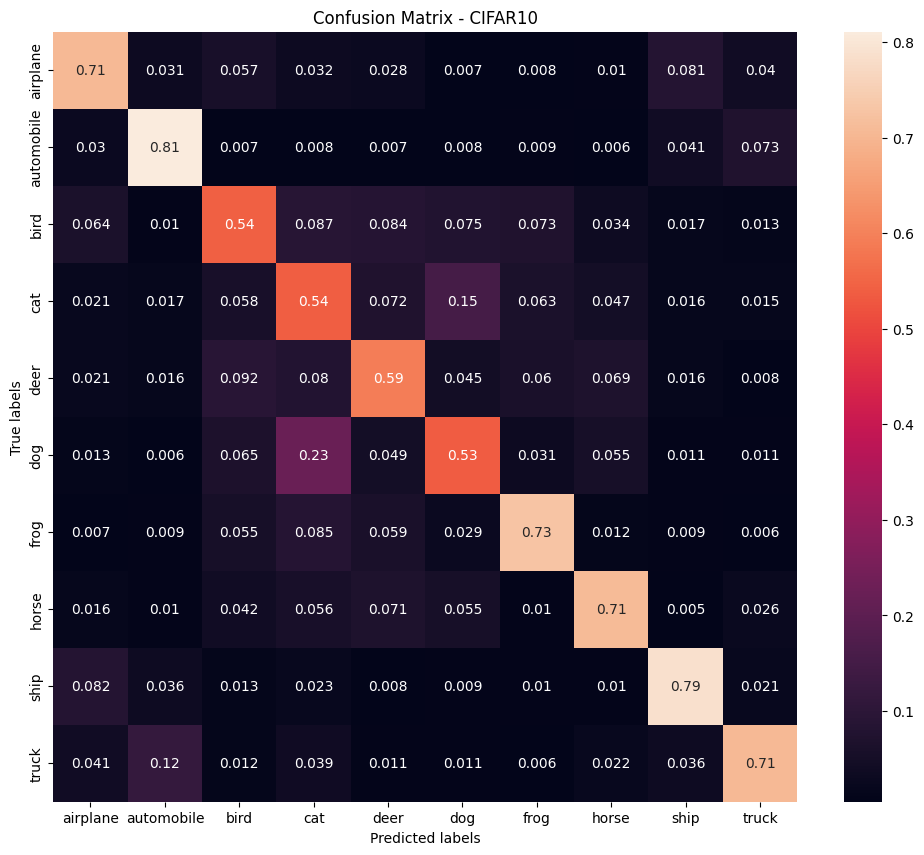

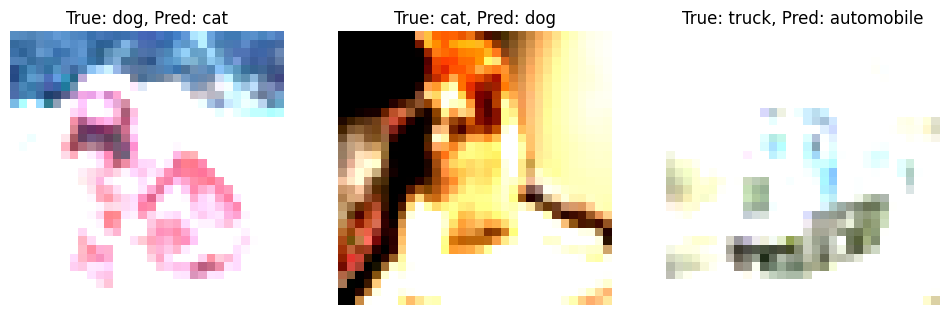

In [44]:
cifar_model_path = base_path + "CIFAR10_39_66.58.pt"
cifar_model = Net(num_channels=3)
cifar_model.load_state_dict(torch.load(cifar_model_path))

_, test_loader = load_data("CIFAR10")

y_actual, y_pred_probabilities = get_prediction_probabilites(cifar_model, test_loader)

y_pred = torch.argmax(y_pred_probabilities, dim=1)

cm = confusion_matrix(y_actual, y_pred, normalize='true')
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - CIFAR10')
plt.show()

print()
print()
find_confusing_images(test_loader, y_pred, y_actual, class_names=class_names, num_channels=3)

In [52]:
def get_roc_auc(y_true, y_pred):
    n = y_pred.size(1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    return fpr, tpr, roc_auc

Files already downloaded and verified
Files already downloaded and verified
data loaded successfully...
Average AUC ROC 0.9407257944444444


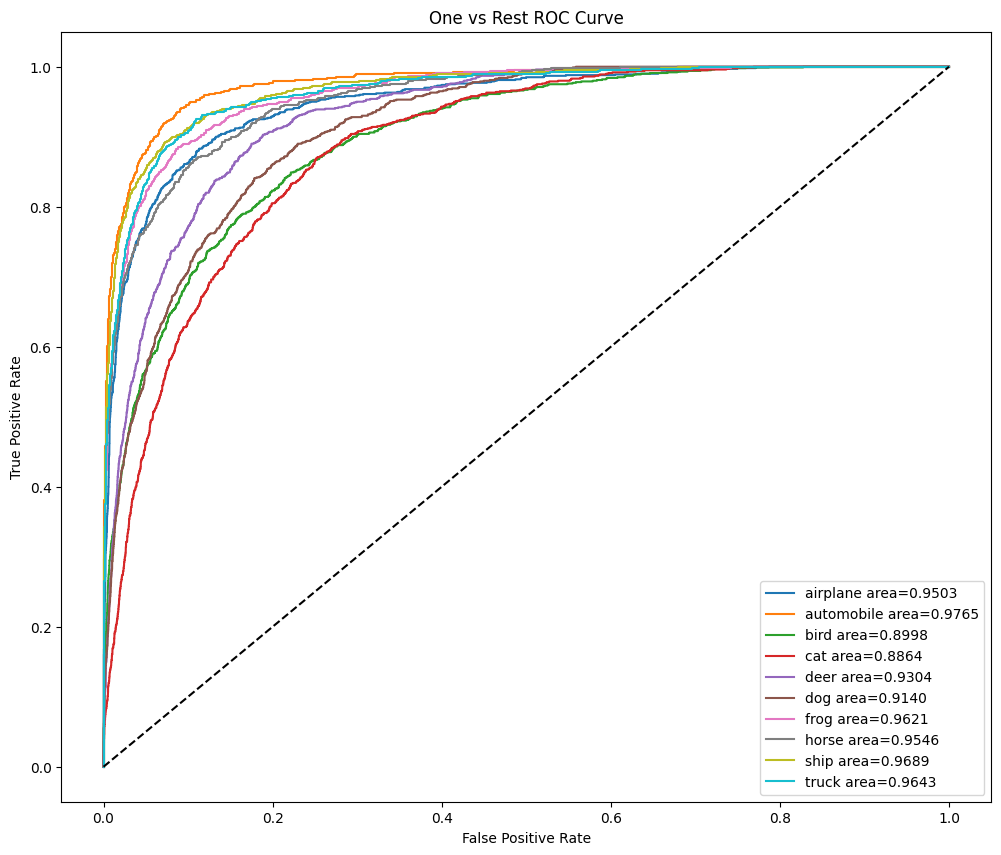

In [54]:
cifar_model_path = base_path + "CIFAR10_39_66.58.pt"
cifar_model = Net(num_channels=3)
cifar_model.load_state_dict(torch.load(cifar_model_path))

train_loader, test_loader = load_data("CIFAR10")

y_true, y_pred = get_prediction_probabilites(cifar_model, test_loader)

fpr, tpr, roc_auc = get_roc_auc(y_true, y_pred.softmax(dim=1))

print("Average AUC ROC", sum(roc_auc.values())/len(roc_auc))

class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

plt.figure(figsize=(12, 10))
for i in range(y_pred.size(1)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} area={roc_auc[i]:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One vs Rest ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def add_noise(labels, noise_rate=0.5):
    labels_count = Counter(labels.tolist())

    error_rate = [int(noise_rate * labels_count[i]) for i in range(10)]

    noisy_labels = [i.item() for i in labels]

    for i in range(len(labels)):
        cur_label = labels[i]
        if error_rate[cur_label] > 0:
            error_rate[cur_label] = error_rate[cur_label] - 1
            random_label = torch.randint(0, 10, (1,))
            while(random_label == labels[i]):
                random_label = torch.randint(0, 10, (1,))
            noisy_labels[i] = random_label.item()

    return noisy_labels

In [ ]:
def get_fashion_mnist_data():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ]
    )
    train_set = tv.datasets.FashionMNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )
    test_set = tv.datasets.FashionMNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform
    )

    return train_set, test_set

In [ ]:
def get_noisy_fashion_loader(train_batch_size=64, test_batch_size=100, noise_rate=0.5):
    train_set, test_set = get_fashion_mnist_data()

    labels = train_set.targets

    noisy_labels = add_noise(labels, noise_rate=noise_rate)

    train_set.targets = torch.tensor(noisy_labels, dtype=torch.long)

    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )

    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )

    return train_loader, test_loader

In [ ]:
def train_model_with_noise(
    model_number=1,
    noise_rate=0.5,
    learning_rate=0.001,
    max_epoch=15,
    optimizerName="SGD",
    add_scheduler=False,
    momentum=0.9,
    decay=0.9,
    step_size=15,
    train_batch_size=64,
    test_batch_size=1000,
):
    # input MNIST
    train_loader, test_loader = get_noisy_fashion_loader(
        train_batch_size=train_batch_size,
        test_batch_size=test_batch_size,
        noise_rate=noise_rate
    )

    # new model
    net = Net()

    # training
    learning_rate = learning_rate
    momentum = momentum
    max_epoch = max_epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    scheduler=None

    if optimizerName == "SGD":
        optimizer = optim.SGD(
            net.parameters(),
            lr=learning_rate,
            momentum=momentum
        )

    if optimizerName == "Adam":
        optimizer = optim.Adam(
            net.parameters(),
            lr=learning_rate,
        )

    if add_scheduler:
        scheduler = StepLR(optimizer, step_size=step_size, gamma=decay)

    train_acc = []
    test_acc = []
    max_acc = 0

    for epoch in range(max_epoch):
        net.train()
        running_loss = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs, labels

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if i % 200 == 199:
                print(
                    "[epoch %d, iter %5d] loss: %.3f" %
                    (epoch + 1, i + 1, running_loss / 200)
                )
                running_loss = 0.0

        if add_scheduler:
            scheduler.step()

        train_acc_t, _ = accuracy(net, train_loader)
        test_acc_t, _ = accuracy(net, test_loader)

        print(
            "epoch %d: train_acc %.3f, test_acc %.3f" % (
                epoch + 1, train_acc_t, test_acc_t
            )
        )

        train_acc.append(train_acc_t)
        test_acc.append(test_acc_t)
        if (test_acc_t > max_acc):
            path = base_path + "Fashion/model" + "_" + str(model_number) + "_" + str(test_acc_t) + ".pt"
            torch.save(net.state_dict(), path)
            max_acc = test_acc_t

    display(train_acc, test_acc)

    return net

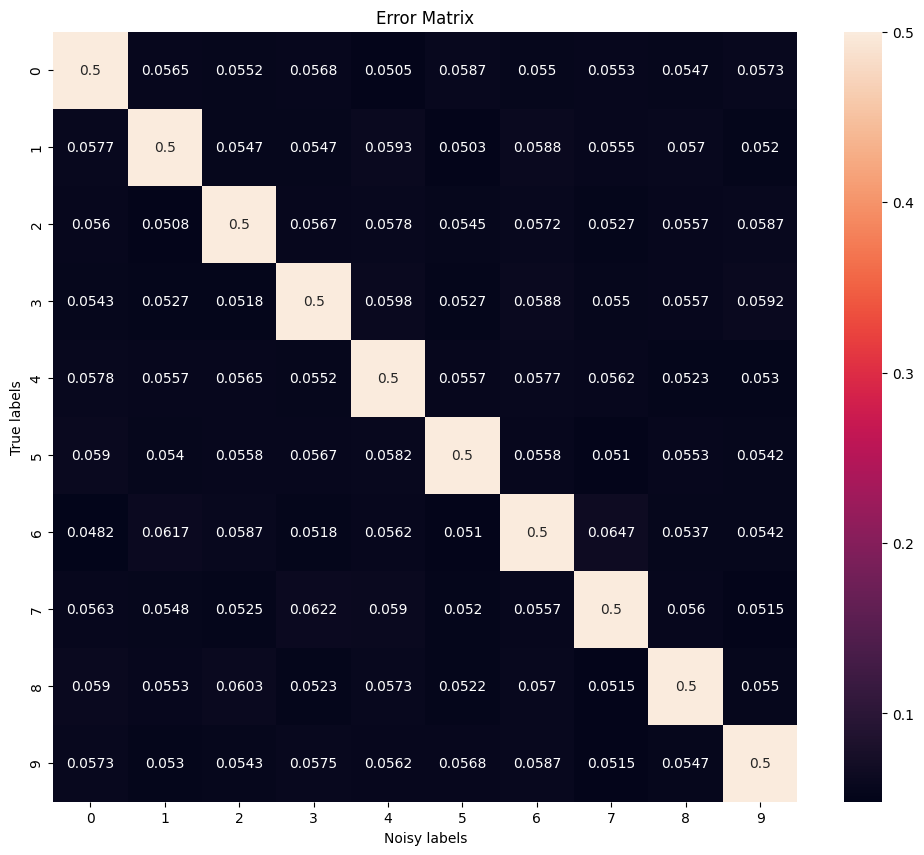

In [ ]:
train_set, _ = get_fashion_mnist_data()

labels = train_set.targets

noisy_labels = add_noise(labels, noise_rate=0.5)

cm = confusion_matrix(labels, noisy_labels, normalize='true')

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".3g")
plt.xlabel('Noisy labels')
plt.ylabel('True labels')
plt.title('Error Matrix')
plt.show()

[epoch 1, iter   200] loss: 2.274
[epoch 1, iter   400] loss: 1.613
[epoch 1, iter   600] loss: 0.913
[epoch 1, iter   800] loss: 0.770
[epoch 1, iter  1000] loss: 0.722
[epoch 1, iter  1200] loss: 0.726
[epoch 1, iter  1400] loss: 0.649
[epoch 1, iter  1600] loss: 0.615
[epoch 1, iter  1800] loss: 0.595
epoch 1: train_acc 79.460, test_acc 78.120
[epoch 2, iter   200] loss: 0.570
[epoch 2, iter   400] loss: 0.552
[epoch 2, iter   600] loss: 0.516
[epoch 2, iter   800] loss: 0.513
[epoch 2, iter  1000] loss: 0.511
[epoch 2, iter  1200] loss: 0.495
[epoch 2, iter  1400] loss: 0.491
[epoch 2, iter  1600] loss: 0.445
[epoch 2, iter  1800] loss: 0.457
epoch 2: train_acc 84.138, test_acc 83.480
[epoch 3, iter   200] loss: 0.461
[epoch 3, iter   400] loss: 0.426
[epoch 3, iter   600] loss: 0.422
[epoch 3, iter   800] loss: 0.416
[epoch 3, iter  1000] loss: 0.431
[epoch 3, iter  1200] loss: 0.405
[epoch 3, iter  1400] loss: 0.402
[epoch 3, iter  1600] loss: 0.415
[epoch 3, iter  1800] loss: 0.

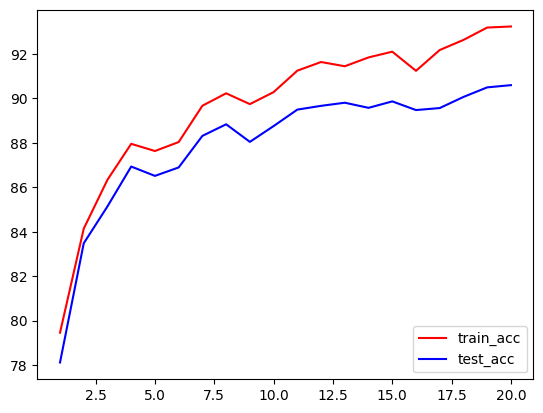

In [ ]:
noisy_fashion_model1 = train_model_with_noise(model_number=1, noise_rate=0, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

tensor([9, 0, 0,  ..., 3, 0, 5])
tensor([9, 0, 0,  ..., 3, 0, 5])
[epoch 1, iter   200] loss: 2.292
[epoch 1, iter   400] loss: 2.145
[epoch 1, iter   600] loss: 1.126
[epoch 1, iter   800] loss: 0.899
[epoch 1, iter  1000] loss: 0.791
[epoch 1, iter  1200] loss: 0.724
[epoch 1, iter  1400] loss: 0.716
[epoch 1, iter  1600] loss: 0.633
[epoch 1, iter  1800] loss: 0.634
epoch 1: train_acc 77.325, test_acc 76.750
[epoch 2, iter   200] loss: 0.582
[epoch 2, iter   400] loss: 0.572
[epoch 2, iter   600] loss: 0.565
[epoch 2, iter   800] loss: 0.540
[epoch 2, iter  1000] loss: 0.523
[epoch 2, iter  1200] loss: 0.523
[epoch 2, iter  1400] loss: 0.500
[epoch 2, iter  1600] loss: 0.523
[epoch 2, iter  1800] loss: 0.493
epoch 2: train_acc 83.927, test_acc 82.900
[epoch 3, iter   200] loss: 0.469
[epoch 3, iter   400] loss: 0.432
[epoch 3, iter   600] loss: 0.450
[epoch 3, iter   800] loss: 0.451
[epoch 3, iter  1000] loss: 0.443
[epoch 3, iter  1200] loss: 0.440
[epoch 3, iter  1400] loss: 0.43

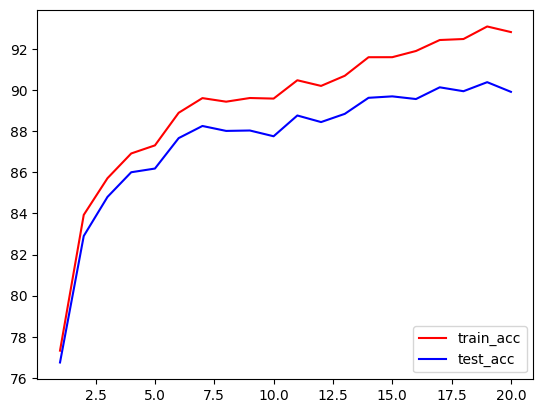

In [ ]:
noisy_fashion_model2 = train_model_with_noise(model_number=2, noise_rate=0, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.296
[epoch 1, iter   400] loss: 2.158
[epoch 1, iter   600] loss: 1.157
[epoch 1, iter   800] loss: 0.927
[epoch 1, iter  1000] loss: 0.815
[epoch 1, iter  1200] loss: 0.744
[epoch 1, iter  1400] loss: 0.720
[epoch 1, iter  1600] loss: 0.675
[epoch 1, iter  1800] loss: 0.629
epoch 1: train_acc 75.788, test_acc 75.050
[epoch 2, iter   200] loss: 0.611
[epoch 2, iter   400] loss: 0.590
[epoch 2, iter   600] loss: 0.559
[epoch 2, iter   800] loss: 0.561
[epoch 2, iter  1000] loss: 0.563
[epoch 2, iter  1200] loss: 0.539
[epoch 2, iter  1400] loss: 0.511
[epoch 2, iter  1600] loss: 0.500
[epoch 2, iter  1800] loss: 0.474
epoch 2: train_acc 83.145, test_acc 82.290
[epoch 3, iter   200] loss: 0.481
[epoch 3, iter   400] loss: 0.479
[epoch 3, iter   600] loss: 0.491
[epoch 3, iter   800] loss: 0.448
[epoch 3, iter  1000] loss: 0.443
[epoch 3, iter  1200] loss: 0.448
[epoch 3, iter  1400] loss: 0.424
[epoch 3, iter  1600] loss: 0.431
[epoch 3, iter  1800] loss: 0.

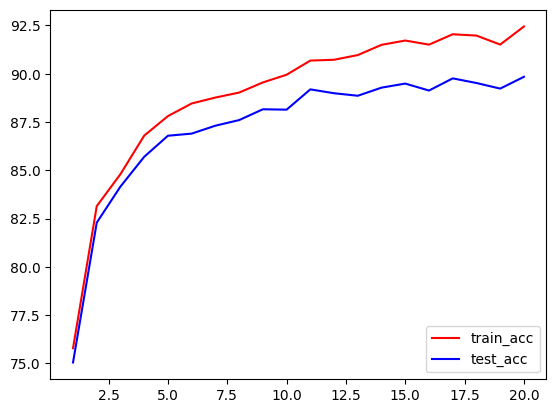

In [ ]:
noisy_fashion_model3 = train_model_with_noise(model_number=3, noise_rate=0, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.229
[epoch 1, iter   400] loss: 1.236
[epoch 1, iter   600] loss: 0.921
[epoch 1, iter   800] loss: 0.817
[epoch 1, iter  1000] loss: 0.741
[epoch 1, iter  1200] loss: 0.696
[epoch 1, iter  1400] loss: 0.646
[epoch 1, iter  1600] loss: 0.590
[epoch 1, iter  1800] loss: 0.602
epoch 1: train_acc 76.667, test_acc 76.130
[epoch 2, iter   200] loss: 0.565
[epoch 2, iter   400] loss: 0.551
[epoch 2, iter   600] loss: 0.529
[epoch 2, iter   800] loss: 0.497
[epoch 2, iter  1000] loss: 0.498
[epoch 2, iter  1200] loss: 0.492
[epoch 2, iter  1400] loss: 0.473
[epoch 2, iter  1600] loss: 0.473
[epoch 2, iter  1800] loss: 0.468
epoch 2: train_acc 83.918, test_acc 83.140
[epoch 3, iter   200] loss: 0.436
[epoch 3, iter   400] loss: 0.439
[epoch 3, iter   600] loss: 0.455
[epoch 3, iter   800] loss: 0.432
[epoch 3, iter  1000] loss: 0.419
[epoch 3, iter  1200] loss: 0.411
[epoch 3, iter  1400] loss: 0.420
[epoch 3, iter  1600] loss: 0.398
[epoch 3, iter  1800] loss: 0.

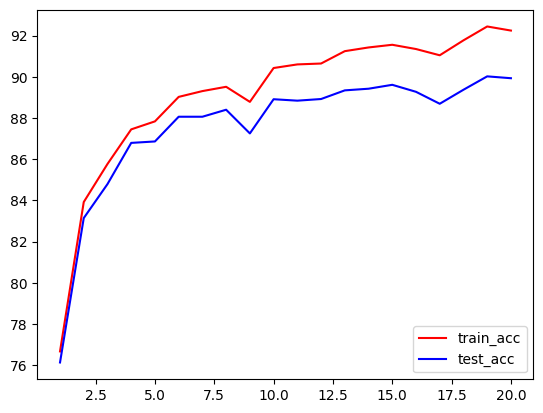

In [ ]:
noisy_fashion_model4 = train_model_with_noise(model_number=4, noise_rate=0, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.297
[epoch 1, iter   400] loss: 2.265
[epoch 1, iter   600] loss: 1.582
[epoch 1, iter   800] loss: 0.920
[epoch 1, iter  1000] loss: 0.811
[epoch 1, iter  1200] loss: 0.770
[epoch 1, iter  1400] loss: 0.705
[epoch 1, iter  1600] loss: 0.682
[epoch 1, iter  1800] loss: 0.625
epoch 1: train_acc 77.227, test_acc 75.860
[epoch 2, iter   200] loss: 0.601
[epoch 2, iter   400] loss: 0.557
[epoch 2, iter   600] loss: 0.533
[epoch 2, iter   800] loss: 0.540
[epoch 2, iter  1000] loss: 0.513
[epoch 2, iter  1200] loss: 0.496
[epoch 2, iter  1400] loss: 0.486
[epoch 2, iter  1600] loss: 0.506
[epoch 2, iter  1800] loss: 0.458
epoch 2: train_acc 83.770, test_acc 82.650
[epoch 3, iter   200] loss: 0.459
[epoch 3, iter   400] loss: 0.432
[epoch 3, iter   600] loss: 0.438
[epoch 3, iter   800] loss: 0.430
[epoch 3, iter  1000] loss: 0.423
[epoch 3, iter  1200] loss: 0.425
[epoch 3, iter  1400] loss: 0.418
[epoch 3, iter  1600] loss: 0.396
[epoch 3, iter  1800] loss: 0.

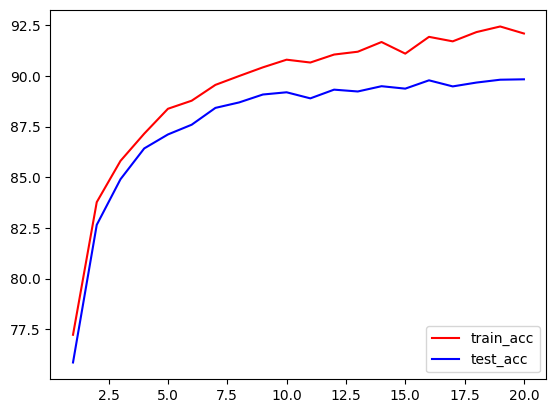

In [ ]:
noisy_fashion_model5 = train_model_with_noise(model_number=5, noise_rate=0, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.291
[epoch 1, iter   400] loss: 2.149
[epoch 1, iter   600] loss: 1.676
[epoch 1, iter   800] loss: 1.558
[epoch 1, iter  1000] loss: 1.505
[epoch 1, iter  1200] loss: 1.453
[epoch 1, iter  1400] loss: 1.423
[epoch 1, iter  1600] loss: 1.410
[epoch 1, iter  1800] loss: 1.392
epoch 1: train_acc 61.112, test_acc 74.660
[epoch 2, iter   200] loss: 1.393
[epoch 2, iter   400] loss: 1.364
[epoch 2, iter   600] loss: 1.320
[epoch 2, iter   800] loss: 1.327
[epoch 2, iter  1000] loss: 1.305
[epoch 2, iter  1200] loss: 1.320
[epoch 2, iter  1400] loss: 1.314
[epoch 2, iter  1600] loss: 1.275
[epoch 2, iter  1800] loss: 1.268
epoch 2: train_acc 66.195, test_acc 81.580
[epoch 3, iter   200] loss: 1.238
[epoch 3, iter   400] loss: 1.287
[epoch 3, iter   600] loss: 1.270
[epoch 3, iter   800] loss: 1.258
[epoch 3, iter  1000] loss: 1.266
[epoch 3, iter  1200] loss: 1.243
[epoch 3, iter  1400] loss: 1.251
[epoch 3, iter  1600] loss: 1.275
[epoch 3, iter  1800] loss: 1.

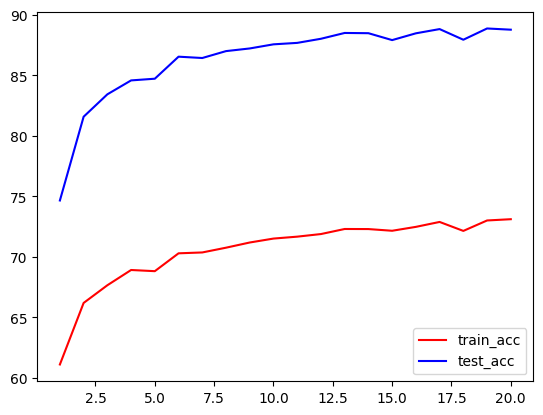

In [ ]:
noisy_fashion_model6 = train_model_with_noise(model_number=6, noise_rate=0.2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.301
[epoch 1, iter   400] loss: 2.288
[epoch 1, iter   600] loss: 2.161
[epoch 1, iter   800] loss: 1.683
[epoch 1, iter  1000] loss: 1.559
[epoch 1, iter  1200] loss: 1.519
[epoch 1, iter  1400] loss: 1.458
[epoch 1, iter  1600] loss: 1.417
[epoch 1, iter  1800] loss: 1.403
epoch 1: train_acc 61.448, test_acc 75.500
[epoch 2, iter   200] loss: 1.361
[epoch 2, iter   400] loss: 1.367
[epoch 2, iter   600] loss: 1.353
[epoch 2, iter   800] loss: 1.340
[epoch 2, iter  1000] loss: 1.352
[epoch 2, iter  1200] loss: 1.314
[epoch 2, iter  1400] loss: 1.320
[epoch 2, iter  1600] loss: 1.315
[epoch 2, iter  1800] loss: 1.299
epoch 2: train_acc 64.943, test_acc 79.960
[epoch 3, iter   200] loss: 1.287
[epoch 3, iter   400] loss: 1.311
[epoch 3, iter   600] loss: 1.293
[epoch 3, iter   800] loss: 1.269
[epoch 3, iter  1000] loss: 1.237
[epoch 3, iter  1200] loss: 1.263
[epoch 3, iter  1400] loss: 1.255
[epoch 3, iter  1600] loss: 1.239
[epoch 3, iter  1800] loss: 1.

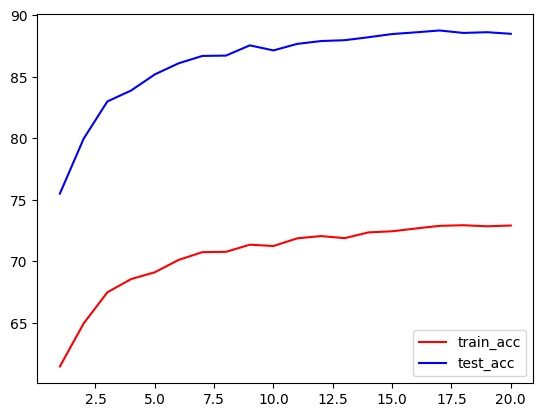

In [ ]:
noisy_fashion_model7 = train_model_with_noise(model_number=7, noise_rate=0.2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.280
[epoch 1, iter   400] loss: 1.918
[epoch 1, iter   600] loss: 1.629
[epoch 1, iter   800] loss: 1.558
[epoch 1, iter  1000] loss: 1.511
[epoch 1, iter  1200] loss: 1.457
[epoch 1, iter  1400] loss: 1.432
[epoch 1, iter  1600] loss: 1.404
[epoch 1, iter  1800] loss: 1.399
epoch 1: train_acc 60.933, test_acc 74.610
[epoch 2, iter   200] loss: 1.389
[epoch 2, iter   400] loss: 1.351
[epoch 2, iter   600] loss: 1.337
[epoch 2, iter   800] loss: 1.331
[epoch 2, iter  1000] loss: 1.329
[epoch 2, iter  1200] loss: 1.299
[epoch 2, iter  1400] loss: 1.341
[epoch 2, iter  1600] loss: 1.320
[epoch 2, iter  1800] loss: 1.320
epoch 2: train_acc 64.988, test_acc 79.530
[epoch 3, iter   200] loss: 1.304
[epoch 3, iter   400] loss: 1.290
[epoch 3, iter   600] loss: 1.299
[epoch 3, iter   800] loss: 1.265
[epoch 3, iter  1000] loss: 1.270
[epoch 3, iter  1200] loss: 1.285
[epoch 3, iter  1400] loss: 1.268
[epoch 3, iter  1600] loss: 1.253
[epoch 3, iter  1800] loss: 1.

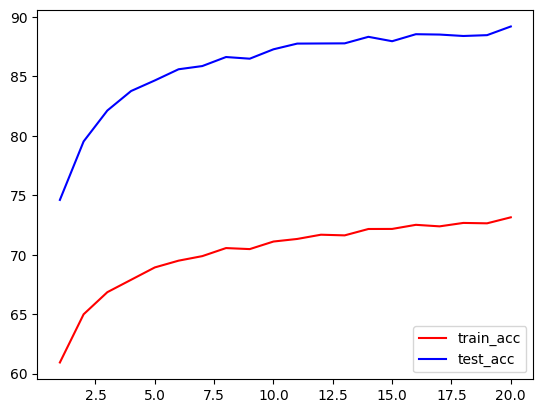

In [ ]:
noisy_fashion_model8 = train_model_with_noise(model_number=8, noise_rate=0.2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.288
[epoch 1, iter   400] loss: 2.122
[epoch 1, iter   600] loss: 1.671
[epoch 1, iter   800] loss: 1.559
[epoch 1, iter  1000] loss: 1.468
[epoch 1, iter  1200] loss: 1.448
[epoch 1, iter  1400] loss: 1.415
[epoch 1, iter  1600] loss: 1.428
[epoch 1, iter  1800] loss: 1.383
epoch 1: train_acc 62.602, test_acc 76.890
[epoch 2, iter   200] loss: 1.364
[epoch 2, iter   400] loss: 1.351
[epoch 2, iter   600] loss: 1.319
[epoch 2, iter   800] loss: 1.347
[epoch 2, iter  1000] loss: 1.290
[epoch 2, iter  1200] loss: 1.291
[epoch 2, iter  1400] loss: 1.313
[epoch 2, iter  1600] loss: 1.328
[epoch 2, iter  1800] loss: 1.317
epoch 2: train_acc 65.873, test_acc 80.810
[epoch 3, iter   200] loss: 1.305
[epoch 3, iter   400] loss: 1.266
[epoch 3, iter   600] loss: 1.269
[epoch 3, iter   800] loss: 1.289
[epoch 3, iter  1000] loss: 1.246
[epoch 3, iter  1200] loss: 1.263
[epoch 3, iter  1400] loss: 1.262
[epoch 3, iter  1600] loss: 1.246
[epoch 3, iter  1800] loss: 1.

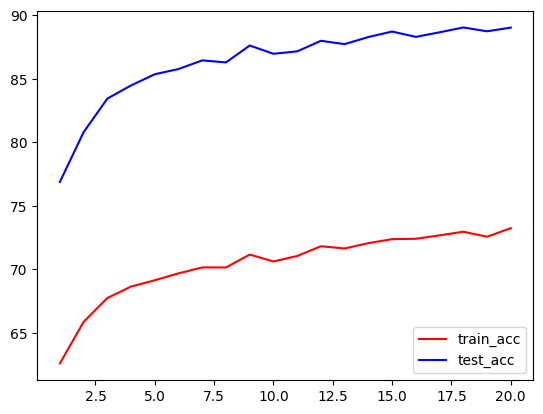

In [ ]:
noisy_fashion_model9 = train_model_with_noise(model_number=9, noise_rate=0.2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.224
[epoch 1, iter   400] loss: 1.738
[epoch 1, iter   600] loss: 1.567
[epoch 1, iter   800] loss: 1.494
[epoch 1, iter  1000] loss: 1.501
[epoch 1, iter  1200] loss: 1.425
[epoch 1, iter  1400] loss: 1.413
[epoch 1, iter  1600] loss: 1.390
[epoch 1, iter  1800] loss: 1.393
epoch 1: train_acc 61.880, test_acc 76.170
[epoch 2, iter   200] loss: 1.367
[epoch 2, iter   400] loss: 1.345
[epoch 2, iter   600] loss: 1.363
[epoch 2, iter   800] loss: 1.336
[epoch 2, iter  1000] loss: 1.320
[epoch 2, iter  1200] loss: 1.299
[epoch 2, iter  1400] loss: 1.320
[epoch 2, iter  1600] loss: 1.286
[epoch 2, iter  1800] loss: 1.292
epoch 2: train_acc 64.405, test_acc 79.310
[epoch 3, iter   200] loss: 1.295
[epoch 3, iter   400] loss: 1.277
[epoch 3, iter   600] loss: 1.282
[epoch 3, iter   800] loss: 1.256
[epoch 3, iter  1000] loss: 1.275
[epoch 3, iter  1200] loss: 1.265
[epoch 3, iter  1400] loss: 1.243
[epoch 3, iter  1600] loss: 1.236
[epoch 3, iter  1800] loss: 1.

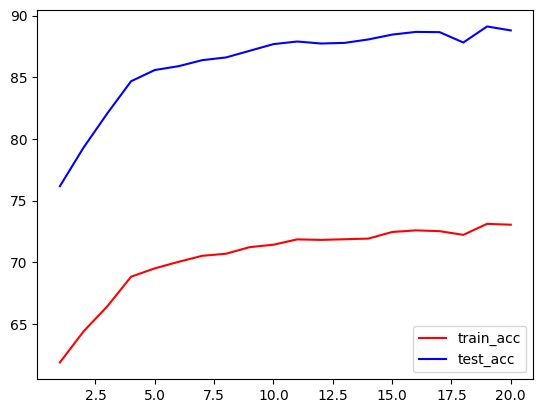

In [ ]:
noisy_fashion_model10 = train_model_with_noise(model_number=10, noise_rate=0.2, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.299
[epoch 1, iter   400] loss: 2.268
[epoch 1, iter   600] loss: 2.086
[epoch 1, iter   800] loss: 1.968
[epoch 1, iter  1000] loss: 1.934
[epoch 1, iter  1200] loss: 1.915
[epoch 1, iter  1400] loss: 1.893
[epoch 1, iter  1600] loss: 1.871
[epoch 1, iter  1800] loss: 1.855
epoch 1: train_acc 44.867, test_acc 72.190
[epoch 2, iter   200] loss: 1.814
[epoch 2, iter   400] loss: 1.849
[epoch 2, iter   600] loss: 1.844
[epoch 2, iter   800] loss: 1.829
[epoch 2, iter  1000] loss: 1.814
[epoch 2, iter  1200] loss: 1.793
[epoch 2, iter  1400] loss: 1.776
[epoch 2, iter  1600] loss: 1.785
[epoch 2, iter  1800] loss: 1.818
epoch 2: train_acc 47.698, test_acc 77.290
[epoch 3, iter   200] loss: 1.791
[epoch 3, iter   400] loss: 1.780
[epoch 3, iter   600] loss: 1.772
[epoch 3, iter   800] loss: 1.780
[epoch 3, iter  1000] loss: 1.797
[epoch 3, iter  1200] loss: 1.786
[epoch 3, iter  1400] loss: 1.765
[epoch 3, iter  1600] loss: 1.775
[epoch 3, iter  1800] loss: 1.

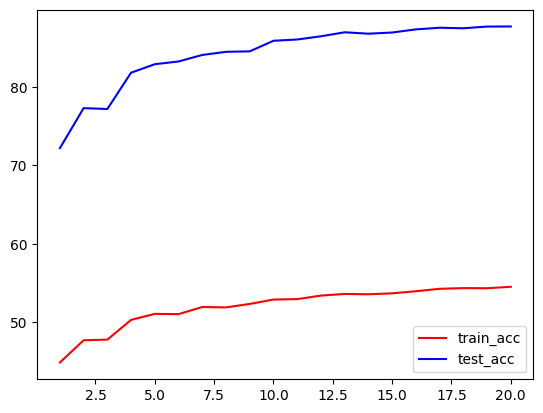

In [ ]:
noisy_fashion_model11 = train_model_with_noise(model_number=11, noise_rate=0.4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.299
[epoch 1, iter   400] loss: 2.273
[epoch 1, iter   600] loss: 2.120
[epoch 1, iter   800] loss: 1.988
[epoch 1, iter  1000] loss: 1.942
[epoch 1, iter  1200] loss: 1.906
[epoch 1, iter  1400] loss: 1.885
[epoch 1, iter  1600] loss: 1.881
[epoch 1, iter  1800] loss: 1.873
epoch 1: train_acc 45.388, test_acc 73.040
[epoch 2, iter   200] loss: 1.831
[epoch 2, iter   400] loss: 1.831
[epoch 2, iter   600] loss: 1.825
[epoch 2, iter   800] loss: 1.821
[epoch 2, iter  1000] loss: 1.806
[epoch 2, iter  1200] loss: 1.787
[epoch 2, iter  1400] loss: 1.806
[epoch 2, iter  1600] loss: 1.798
[epoch 2, iter  1800] loss: 1.797
epoch 2: train_acc 48.515, test_acc 78.160
[epoch 3, iter   200] loss: 1.788
[epoch 3, iter   400] loss: 1.771
[epoch 3, iter   600] loss: 1.755
[epoch 3, iter   800] loss: 1.798
[epoch 3, iter  1000] loss: 1.762
[epoch 3, iter  1200] loss: 1.778
[epoch 3, iter  1400] loss: 1.770
[epoch 3, iter  1600] loss: 1.765
[epoch 3, iter  1800] loss: 1.

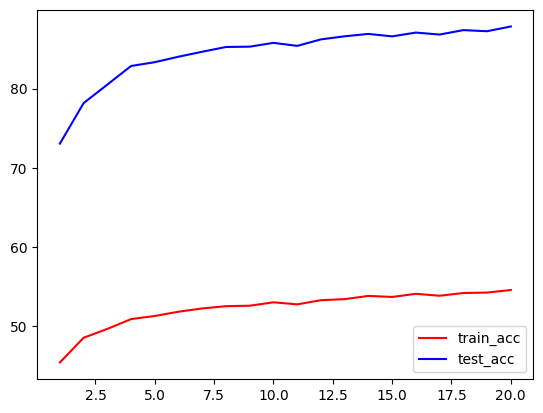

In [ ]:
noisy_fashion_model12 = train_model_with_noise(model_number=12, noise_rate=0.4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.299
[epoch 1, iter   400] loss: 2.265
[epoch 1, iter   600] loss: 2.100
[epoch 1, iter   800] loss: 1.987
[epoch 1, iter  1000] loss: 1.950
[epoch 1, iter  1200] loss: 1.886
[epoch 1, iter  1400] loss: 1.872
[epoch 1, iter  1600] loss: 1.853
[epoch 1, iter  1800] loss: 1.852
epoch 1: train_acc 44.327, test_acc 71.270
[epoch 2, iter   200] loss: 1.843
[epoch 2, iter   400] loss: 1.822
[epoch 2, iter   600] loss: 1.842
[epoch 2, iter   800] loss: 1.807
[epoch 2, iter  1000] loss: 1.822
[epoch 2, iter  1200] loss: 1.795
[epoch 2, iter  1400] loss: 1.782
[epoch 2, iter  1600] loss: 1.819
[epoch 2, iter  1800] loss: 1.780
epoch 2: train_acc 47.347, test_acc 75.920
[epoch 3, iter   200] loss: 1.799
[epoch 3, iter   400] loss: 1.781
[epoch 3, iter   600] loss: 1.790
[epoch 3, iter   800] loss: 1.773
[epoch 3, iter  1000] loss: 1.747
[epoch 3, iter  1200] loss: 1.772
[epoch 3, iter  1400] loss: 1.762
[epoch 3, iter  1600] loss: 1.767
[epoch 3, iter  1800] loss: 1.

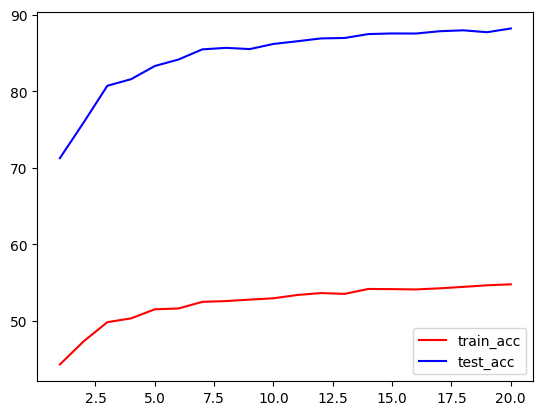

In [ ]:
noisy_fashion_model13 = train_model_with_noise(model_number=13, noise_rate=0.4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.291
[epoch 1, iter   400] loss: 2.192
[epoch 1, iter   600] loss: 2.012
[epoch 1, iter   800] loss: 1.973
[epoch 1, iter  1000] loss: 1.925
[epoch 1, iter  1200] loss: 1.893
[epoch 1, iter  1400] loss: 1.890
[epoch 1, iter  1600] loss: 1.889
[epoch 1, iter  1800] loss: 1.847
epoch 1: train_acc 44.628, test_acc 71.990
[epoch 2, iter   200] loss: 1.862
[epoch 2, iter   400] loss: 1.835
[epoch 2, iter   600] loss: 1.828
[epoch 2, iter   800] loss: 1.831
[epoch 2, iter  1000] loss: 1.820
[epoch 2, iter  1200] loss: 1.801
[epoch 2, iter  1400] loss: 1.820
[epoch 2, iter  1600] loss: 1.801
[epoch 2, iter  1800] loss: 1.789
epoch 2: train_acc 47.725, test_acc 77.180
[epoch 3, iter   200] loss: 1.814
[epoch 3, iter   400] loss: 1.797
[epoch 3, iter   600] loss: 1.775
[epoch 3, iter   800] loss: 1.780
[epoch 3, iter  1000] loss: 1.764
[epoch 3, iter  1200] loss: 1.758
[epoch 3, iter  1400] loss: 1.766
[epoch 3, iter  1600] loss: 1.787
[epoch 3, iter  1800] loss: 1.

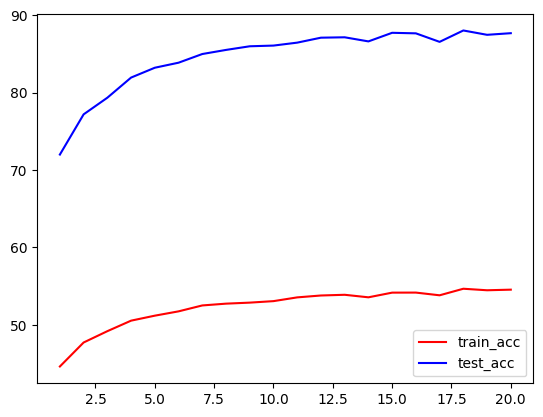

In [ ]:
noisy_fashion_model14 = train_model_with_noise(model_number=14, noise_rate=0.4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.300
[epoch 1, iter   400] loss: 2.275
[epoch 1, iter   600] loss: 2.118
[epoch 1, iter   800] loss: 1.954
[epoch 1, iter  1000] loss: 1.916
[epoch 1, iter  1200] loss: 1.880
[epoch 1, iter  1400] loss: 1.859
[epoch 1, iter  1600] loss: 1.845
[epoch 1, iter  1800] loss: 1.840
epoch 1: train_acc 46.425, test_acc 74.240
[epoch 2, iter   200] loss: 1.834
[epoch 2, iter   400] loss: 1.825
[epoch 2, iter   600] loss: 1.817
[epoch 2, iter   800] loss: 1.812
[epoch 2, iter  1000] loss: 1.767
[epoch 2, iter  1200] loss: 1.779
[epoch 2, iter  1400] loss: 1.815
[epoch 2, iter  1600] loss: 1.783
[epoch 2, iter  1800] loss: 1.780
epoch 2: train_acc 47.798, test_acc 77.040
[epoch 3, iter   200] loss: 1.778
[epoch 3, iter   400] loss: 1.798
[epoch 3, iter   600] loss: 1.771
[epoch 3, iter   800] loss: 1.753
[epoch 3, iter  1000] loss: 1.769
[epoch 3, iter  1200] loss: 1.761
[epoch 3, iter  1400] loss: 1.777
[epoch 3, iter  1600] loss: 1.750
[epoch 3, iter  1800] loss: 1.

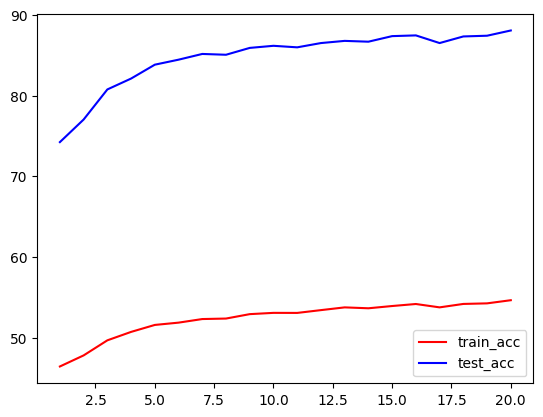

In [ ]:
noisy_fashion_model15 = train_model_with_noise(model_number=15, noise_rate=0.4, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.301
[epoch 1, iter   400] loss: 2.290
[epoch 1, iter   600] loss: 2.264
[epoch 1, iter   800] loss: 2.213
[epoch 1, iter  1000] loss: 2.198
[epoch 1, iter  1200] loss: 2.181
[epoch 1, iter  1400] loss: 2.178
[epoch 1, iter  1600] loss: 2.174
[epoch 1, iter  1800] loss: 2.149
epoch 1: train_acc 27.657, test_acc 62.890
[epoch 2, iter   200] loss: 2.143
[epoch 2, iter   400] loss: 2.149
[epoch 2, iter   600] loss: 2.135
[epoch 2, iter   800] loss: 2.145
[epoch 2, iter  1000] loss: 2.127
[epoch 2, iter  1200] loss: 2.118
[epoch 2, iter  1400] loss: 2.123
[epoch 2, iter  1600] loss: 2.128
[epoch 2, iter  1800] loss: 2.122
epoch 2: train_acc 30.853, test_acc 71.350
[epoch 3, iter   200] loss: 2.112
[epoch 3, iter   400] loss: 2.116
[epoch 3, iter   600] loss: 2.123
[epoch 3, iter   800] loss: 2.129
[epoch 3, iter  1000] loss: 2.108
[epoch 3, iter  1200] loss: 2.119
[epoch 3, iter  1400] loss: 2.102
[epoch 3, iter  1600] loss: 2.109
[epoch 3, iter  1800] loss: 2.

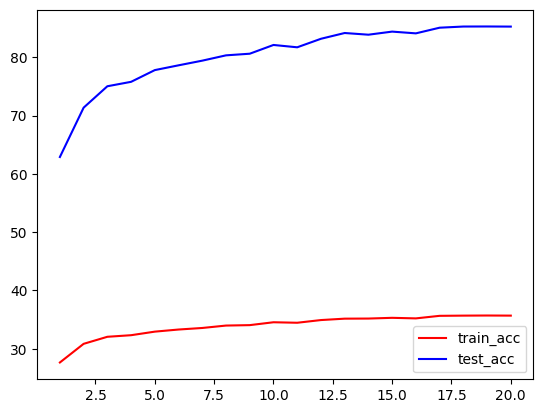

In [ ]:
noisy_fashion_model16 = train_model_with_noise(model_number=16, noise_rate=0.6, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.303
[epoch 1, iter   400] loss: 2.297
[epoch 1, iter   600] loss: 2.284
[epoch 1, iter   800] loss: 2.252
[epoch 1, iter  1000] loss: 2.207
[epoch 1, iter  1200] loss: 2.180
[epoch 1, iter  1400] loss: 2.164
[epoch 1, iter  1600] loss: 2.170
[epoch 1, iter  1800] loss: 2.157
epoch 1: train_acc 28.587, test_acc 65.410
[epoch 2, iter   200] loss: 2.145
[epoch 2, iter   400] loss: 2.137
[epoch 2, iter   600] loss: 2.161
[epoch 2, iter   800] loss: 2.137
[epoch 2, iter  1000] loss: 2.142
[epoch 2, iter  1200] loss: 2.117
[epoch 2, iter  1400] loss: 2.129
[epoch 2, iter  1600] loss: 2.117
[epoch 2, iter  1800] loss: 2.122
epoch 2: train_acc 30.655, test_acc 71.620
[epoch 3, iter   200] loss: 2.130
[epoch 3, iter   400] loss: 2.122
[epoch 3, iter   600] loss: 2.120
[epoch 3, iter   800] loss: 2.111
[epoch 3, iter  1000] loss: 2.123
[epoch 3, iter  1200] loss: 2.105
[epoch 3, iter  1400] loss: 2.110
[epoch 3, iter  1600] loss: 2.098
[epoch 3, iter  1800] loss: 2.

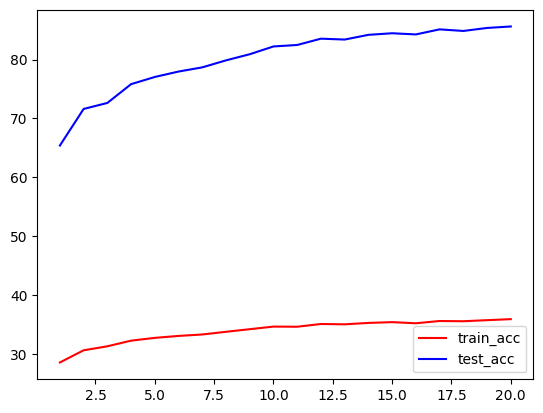

In [ ]:
noisy_fashion_model17 = train_model_with_noise(model_number=17, noise_rate=0.6, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.300
[epoch 1, iter   400] loss: 2.287
[epoch 1, iter   600] loss: 2.258
[epoch 1, iter   800] loss: 2.222
[epoch 1, iter  1000] loss: 2.198
[epoch 1, iter  1200] loss: 2.184
[epoch 1, iter  1400] loss: 2.179
[epoch 1, iter  1600] loss: 2.160
[epoch 1, iter  1800] loss: 2.167
epoch 1: train_acc 28.223, test_acc 64.060
[epoch 2, iter   200] loss: 2.139
[epoch 2, iter   400] loss: 2.146
[epoch 2, iter   600] loss: 2.144
[epoch 2, iter   800] loss: 2.137
[epoch 2, iter  1000] loss: 2.134
[epoch 2, iter  1200] loss: 2.128
[epoch 2, iter  1400] loss: 2.130
[epoch 2, iter  1600] loss: 2.120
[epoch 2, iter  1800] loss: 2.136
epoch 2: train_acc 30.403, test_acc 69.790
[epoch 3, iter   200] loss: 2.118
[epoch 3, iter   400] loss: 2.107
[epoch 3, iter   600] loss: 2.122
[epoch 3, iter   800] loss: 2.110
[epoch 3, iter  1000] loss: 2.120
[epoch 3, iter  1200] loss: 2.119
[epoch 3, iter  1400] loss: 2.110
[epoch 3, iter  1600] loss: 2.106
[epoch 3, iter  1800] loss: 2.

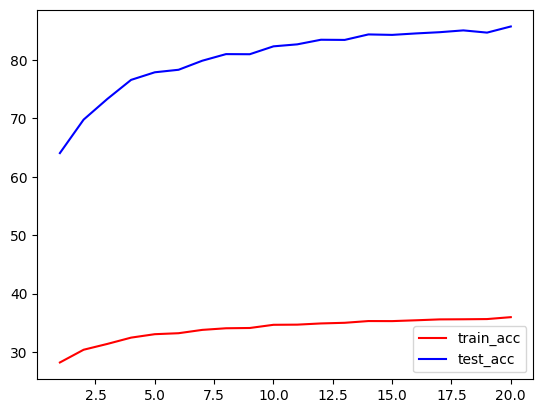

In [ ]:
noisy_fashion_model18 = train_model_with_noise(model_number=18, noise_rate=0.6, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.300
[epoch 1, iter   400] loss: 2.288
[epoch 1, iter   600] loss: 2.256
[epoch 1, iter   800] loss: 2.221
[epoch 1, iter  1000] loss: 2.194
[epoch 1, iter  1200] loss: 2.175
[epoch 1, iter  1400] loss: 2.167
[epoch 1, iter  1600] loss: 2.156
[epoch 1, iter  1800] loss: 2.157
epoch 1: train_acc 28.898, test_acc 66.010
[epoch 2, iter   200] loss: 2.141
[epoch 2, iter   400] loss: 2.146
[epoch 2, iter   600] loss: 2.141
[epoch 2, iter   800] loss: 2.130
[epoch 2, iter  1000] loss: 2.122
[epoch 2, iter  1200] loss: 2.127
[epoch 2, iter  1400] loss: 2.116
[epoch 2, iter  1600] loss: 2.111
[epoch 2, iter  1800] loss: 2.114
epoch 2: train_acc 31.498, test_acc 73.660
[epoch 3, iter   200] loss: 2.118
[epoch 3, iter   400] loss: 2.125
[epoch 3, iter   600] loss: 2.110
[epoch 3, iter   800] loss: 2.108
[epoch 3, iter  1000] loss: 2.110
[epoch 3, iter  1200] loss: 2.081
[epoch 3, iter  1400] loss: 2.116
[epoch 3, iter  1600] loss: 2.097
[epoch 3, iter  1800] loss: 2.

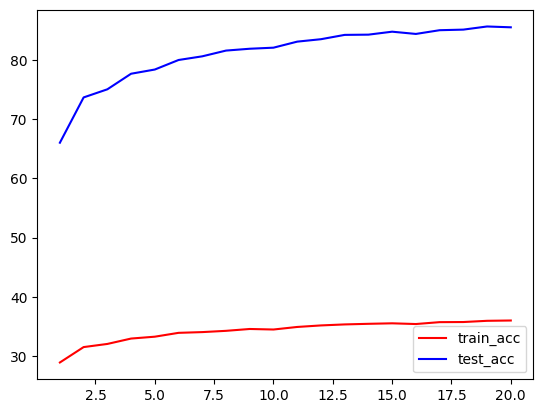

In [ ]:
noisy_fashion_model19 = train_model_with_noise(model_number=19, noise_rate=0.6, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.299
[epoch 1, iter   400] loss: 2.286
[epoch 1, iter   600] loss: 2.252
[epoch 1, iter   800] loss: 2.224
[epoch 1, iter  1000] loss: 2.192
[epoch 1, iter  1200] loss: 2.178
[epoch 1, iter  1400] loss: 2.172
[epoch 1, iter  1600] loss: 2.155
[epoch 1, iter  1800] loss: 2.158
epoch 1: train_acc 28.453, test_acc 64.690
[epoch 2, iter   200] loss: 2.147
[epoch 2, iter   400] loss: 2.151
[epoch 2, iter   600] loss: 2.139
[epoch 2, iter   800] loss: 2.137
[epoch 2, iter  1000] loss: 2.148
[epoch 2, iter  1200] loss: 2.130
[epoch 2, iter  1400] loss: 2.132
[epoch 2, iter  1600] loss: 2.123
[epoch 2, iter  1800] loss: 2.134
epoch 2: train_acc 30.558, test_acc 70.970
[epoch 3, iter   200] loss: 2.126
[epoch 3, iter   400] loss: 2.115
[epoch 3, iter   600] loss: 2.135
[epoch 3, iter   800] loss: 2.113
[epoch 3, iter  1000] loss: 2.122
[epoch 3, iter  1200] loss: 2.119
[epoch 3, iter  1400] loss: 2.105
[epoch 3, iter  1600] loss: 2.111
[epoch 3, iter  1800] loss: 2.

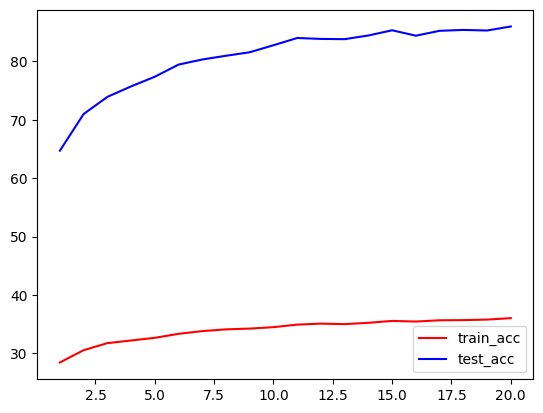

In [ ]:
noisy_fashion_model20 = train_model_with_noise(model_number=20, noise_rate=0.6, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.303
[epoch 1, iter   400] loss: 2.304
[epoch 1, iter   600] loss: 2.303
[epoch 1, iter   800] loss: 2.302
[epoch 1, iter  1000] loss: 2.302
[epoch 1, iter  1200] loss: 2.302
[epoch 1, iter  1400] loss: 2.301
[epoch 1, iter  1600] loss: 2.301
[epoch 1, iter  1800] loss: 2.301
epoch 1: train_acc 10.952, test_acc 17.410
[epoch 2, iter   200] loss: 2.300
[epoch 2, iter   400] loss: 2.299
[epoch 2, iter   600] loss: 2.300
[epoch 2, iter   800] loss: 2.299
[epoch 2, iter  1000] loss: 2.298
[epoch 2, iter  1200] loss: 2.297
[epoch 2, iter  1400] loss: 2.297
[epoch 2, iter  1600] loss: 2.295
[epoch 2, iter  1800] loss: 2.295
epoch 2: train_acc 13.847, test_acc 43.110
[epoch 3, iter   200] loss: 2.291
[epoch 3, iter   400] loss: 2.291
[epoch 3, iter   600] loss: 2.288
[epoch 3, iter   800] loss: 2.290
[epoch 3, iter  1000] loss: 2.290
[epoch 3, iter  1200] loss: 2.285
[epoch 3, iter  1400] loss: 2.287
[epoch 3, iter  1600] loss: 2.288
[epoch 3, iter  1800] loss: 2.

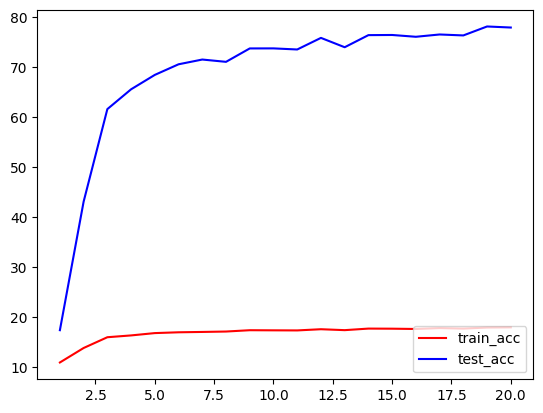

In [ ]:
noisy_fashion_model21 = train_model_with_noise(model_number=21, noise_rate=0.8, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.303
[epoch 1, iter   400] loss: 2.303
[epoch 1, iter   600] loss: 2.303
[epoch 1, iter   800] loss: 2.301
[epoch 1, iter  1000] loss: 2.301
[epoch 1, iter  1200] loss: 2.300
[epoch 1, iter  1400] loss: 2.301
[epoch 1, iter  1600] loss: 2.299
[epoch 1, iter  1800] loss: 2.299
epoch 1: train_acc 12.695, test_acc 33.600
[epoch 2, iter   200] loss: 2.297
[epoch 2, iter   400] loss: 2.296
[epoch 2, iter   600] loss: 2.297
[epoch 2, iter   800] loss: 2.293
[epoch 2, iter  1000] loss: 2.291
[epoch 2, iter  1200] loss: 2.293
[epoch 2, iter  1400] loss: 2.292
[epoch 2, iter  1600] loss: 2.292
[epoch 2, iter  1800] loss: 2.290
epoch 2: train_acc 14.260, test_acc 46.800
[epoch 3, iter   200] loss: 2.290
[epoch 3, iter   400] loss: 2.289
[epoch 3, iter   600] loss: 2.286
[epoch 3, iter   800] loss: 2.286
[epoch 3, iter  1000] loss: 2.288
[epoch 3, iter  1200] loss: 2.289
[epoch 3, iter  1400] loss: 2.286
[epoch 3, iter  1600] loss: 2.283
[epoch 3, iter  1800] loss: 2.

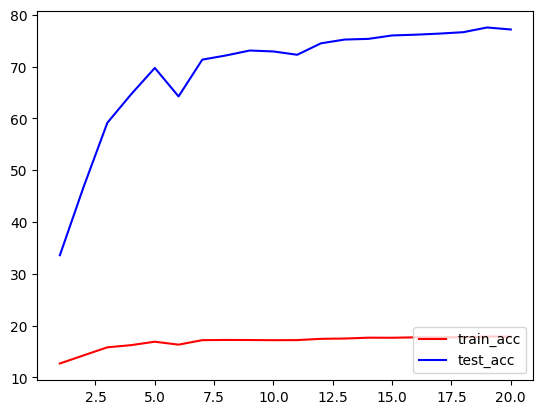

In [ ]:
noisy_fashion_model22 = train_model_with_noise(model_number=22, noise_rate=0.8, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.305
[epoch 1, iter   400] loss: 2.303
[epoch 1, iter   600] loss: 2.303
[epoch 1, iter   800] loss: 2.302
[epoch 1, iter  1000] loss: 2.301
[epoch 1, iter  1200] loss: 2.301
[epoch 1, iter  1400] loss: 2.300
[epoch 1, iter  1600] loss: 2.299
[epoch 1, iter  1800] loss: 2.299
epoch 1: train_acc 14.150, test_acc 46.860
[epoch 2, iter   200] loss: 2.296
[epoch 2, iter   400] loss: 2.296
[epoch 2, iter   600] loss: 2.293
[epoch 2, iter   800] loss: 2.291
[epoch 2, iter  1000] loss: 2.293
[epoch 2, iter  1200] loss: 2.288
[epoch 2, iter  1400] loss: 2.288
[epoch 2, iter  1600] loss: 2.289
[epoch 2, iter  1800] loss: 2.290
epoch 2: train_acc 15.858, test_acc 61.160
[epoch 3, iter   200] loss: 2.285
[epoch 3, iter   400] loss: 2.287
[epoch 3, iter   600] loss: 2.289
[epoch 3, iter   800] loss: 2.283
[epoch 3, iter  1000] loss: 2.285
[epoch 3, iter  1200] loss: 2.287
[epoch 3, iter  1400] loss: 2.281
[epoch 3, iter  1600] loss: 2.288
[epoch 3, iter  1800] loss: 2.

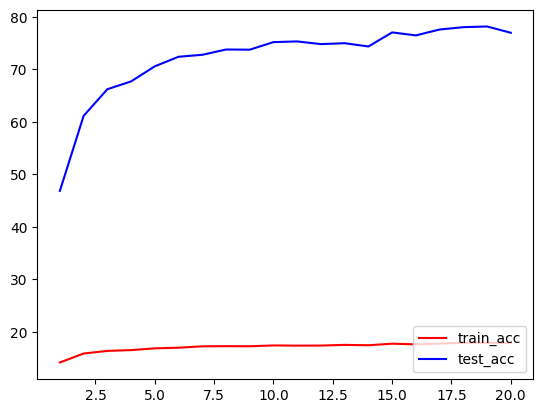

In [ ]:
noisy_fashion_model23 = train_model_with_noise(model_number=23, noise_rate=0.8, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.305
[epoch 1, iter   400] loss: 2.305
[epoch 1, iter   600] loss: 2.303
[epoch 1, iter   800] loss: 2.301
[epoch 1, iter  1000] loss: 2.302
[epoch 1, iter  1200] loss: 2.301
[epoch 1, iter  1400] loss: 2.301
[epoch 1, iter  1600] loss: 2.300
[epoch 1, iter  1800] loss: 2.299
epoch 1: train_acc 12.752, test_acc 32.720
[epoch 2, iter   200] loss: 2.298
[epoch 2, iter   400] loss: 2.297
[epoch 2, iter   600] loss: 2.296
[epoch 2, iter   800] loss: 2.294
[epoch 2, iter  1000] loss: 2.296
[epoch 2, iter  1200] loss: 2.294
[epoch 2, iter  1400] loss: 2.294
[epoch 2, iter  1600] loss: 2.292
[epoch 2, iter  1800] loss: 2.293
epoch 2: train_acc 14.793, test_acc 51.530
[epoch 3, iter   200] loss: 2.288
[epoch 3, iter   400] loss: 2.291
[epoch 3, iter   600] loss: 2.285
[epoch 3, iter   800] loss: 2.290
[epoch 3, iter  1000] loss: 2.287
[epoch 3, iter  1200] loss: 2.287
[epoch 3, iter  1400] loss: 2.292
[epoch 3, iter  1600] loss: 2.289
[epoch 3, iter  1800] loss: 2.

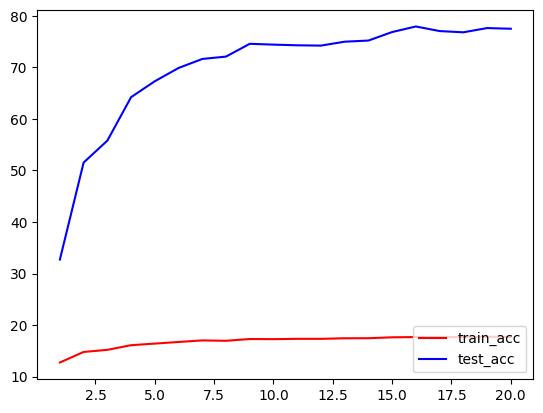

In [ ]:
noisy_fashion_model24 = train_model_with_noise(model_number=24, noise_rate=0.8, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

[epoch 1, iter   200] loss: 2.306
[epoch 1, iter   400] loss: 2.303
[epoch 1, iter   600] loss: 2.301
[epoch 1, iter   800] loss: 2.299
[epoch 1, iter  1000] loss: 2.299
[epoch 1, iter  1200] loss: 2.297
[epoch 1, iter  1400] loss: 2.295
[epoch 1, iter  1600] loss: 2.295
[epoch 1, iter  1800] loss: 2.293
epoch 1: train_acc 14.927, test_acc 51.740
[epoch 2, iter   200] loss: 2.293
[epoch 2, iter   400] loss: 2.292
[epoch 2, iter   600] loss: 2.288
[epoch 2, iter   800] loss: 2.292
[epoch 2, iter  1000] loss: 2.289
[epoch 2, iter  1200] loss: 2.290
[epoch 2, iter  1400] loss: 2.289
[epoch 2, iter  1600] loss: 2.291
[epoch 2, iter  1800] loss: 2.286
epoch 2: train_acc 15.338, test_acc 55.100
[epoch 3, iter   200] loss: 2.287
[epoch 3, iter   400] loss: 2.287
[epoch 3, iter   600] loss: 2.286
[epoch 3, iter   800] loss: 2.289
[epoch 3, iter  1000] loss: 2.284
[epoch 3, iter  1200] loss: 2.284
[epoch 3, iter  1400] loss: 2.287
[epoch 3, iter  1600] loss: 2.285
[epoch 3, iter  1800] loss: 2.

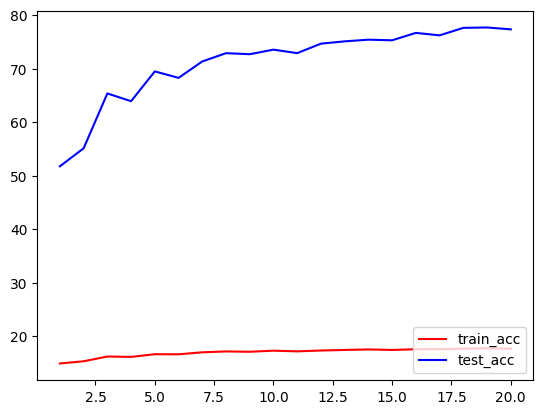

In [ ]:
noisy_fashion_model25 = train_model_with_noise(model_number=25, noise_rate=0.8, learning_rate=0.001, max_epoch=20, train_batch_size=32, test_batch_size=256)

In [ ]:
def plot_accuracy_over_noise(test_accuracies):
    noises = [0, 0.2, 0.4, 0.6, 0.8]

    mean_test_accuracies = {
        i: np.mean(test_accuracies[i]) for i in noises
    }
    std_test_accuracies = {
        i: np.std(test_accuracies[i]) for i in noises
    }

    mean_test_acc = np.array([mean_test_accuracies[i] for i in noises])
    std_test_acc = np.array([std_test_accuracies[i] for i in noises])

    plt.plot(noises, mean_test_acc, color='red', label='Mean Testing Accuracy')
    plt.fill_between(noises, mean_test_acc - std_test_acc, mean_test_acc + std_test_acc, color='red', alpha=0.3)

    plt.xlabel('Noise')
    plt.ylabel('Accuracy')
    plt.title('Epoch vs Testing Accuracy')
    plt.legend()
    # Show plot
    plt.grid(True)
    plt.show()

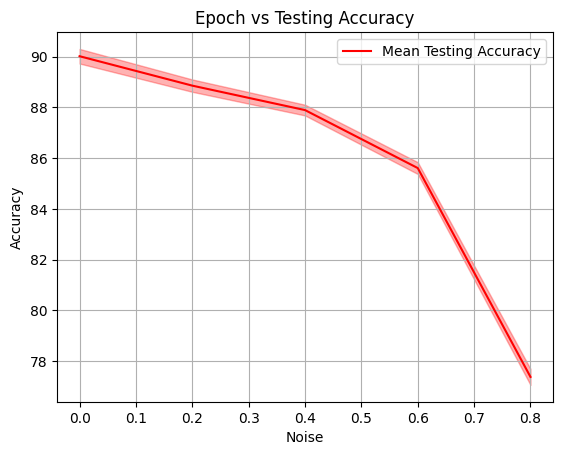

In [ ]:
accuracies = {
    0: [90.590, 89.910, 89.840, 89.930, 89.830],
    0.2: [88.770, 88.490, 89.200, 89.040, 88.800],
    0.4: [87.700, 87.840, 88.200, 87.660, 88.080],
    0.6: [85.250, 85.620, 85.730, 85.500, 85.950],
    0.8: [77.920, 77.180, 76.990, 77.480, 77.310]
}

plot_accuracy_over_noise(accuracies)